In [1]:
import os
import sys
import torch
import warnings
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from IPython.display import HTML
from tabulate import tabulate
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Check if GPU is available (TensorFlow)
print("TensorFlow GPU Available:", tf.config.list_physical_devices('GPU'))

# Check if GPU is available (PyTorch)
print("PyTorch GPU Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

TensorFlow GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PyTorch GPU Available: True
GPU Device Name: Tesla T4


In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [6]:
# ==============================
# Data Loading
# ==============================

# Set the path for Kaggle dataset (adjust based on your Kaggle Notebook setup)
data_path = "../input/playground-series-s5e3/"

In [7]:
def safe_read_csv(filepath, usecols=None, dtype=None):
    """Helper function to safely read CSVs, returning None if the file is missing."""
    if os.path.exists(filepath):
        return pd.read_csv(filepath, usecols=usecols, dtype=dtype)
    else:
        print(f"File {filepath} not found.")
        return None

In [8]:
# Read train and test data
train_data = safe_read_csv(os.path.join(data_path, "train.csv"))
test_data = safe_read_csv(os.path.join(data_path, "test.csv"))

In [9]:
# Print data info
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  

In [10]:
# Display first 5 rows of train_data in a nice tabular format
print("\nTrain Data (First 5 Rows):")
print(tabulate(train_data.head(), headers='keys', tablefmt='psql', showindex=False))

# Display first 5 rows of test_data in a nice tabular format
print("\nTest Data (First 5 Rows):")
print(tabulate(test_data.head(), headers='keys', tablefmt='psql', showindex=False))


Train Data (First 5 Rows):
+------+-------+------------+-----------+---------------+-----------+------------+------------+---------+------------+-----------------+-------------+------------+
|   id |   day |   pressure |   maxtemp |   temparature |   mintemp |   dewpoint |   humidity |   cloud |   sunshine |   winddirection |   windspeed |   rainfall |
|------+-------+------------+-----------+---------------+-----------+------------+------------+---------+------------+-----------------+-------------+------------|
|    0 |     1 |     1017.4 |      21.2 |          20.6 |      19.9 |       19.4 |         87 |      88 |        1.1 |              60 |        17.2 |          1 |
|    1 |     2 |     1019.5 |      16.2 |          16.9 |      15.8 |       15.4 |         95 |      91 |        0   |              50 |        21.9 |          1 |
|    2 |     3 |     1024.1 |      19.4 |          16.1 |      14.6 |        9.3 |         75 |      47 |        8.3 |              70 |        18.1 |  

In [11]:
# Define features and target
feature_cols = ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 
                'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
X = train_data[feature_cols]
y = train_data['rainfall']

In [12]:
# Split the data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_val.shape[0]} rows")


Training set size: 1752 rows
Validation set size: 438 rows


In [13]:
def plot_data(df, plot_type, features=None, target=None, title_prefix=""):
    """
    Functional interface for plotting data.
    
    Parameters:
    - df: DataFrame or NumPy array to plot (train_data, test_data, or predictions for pred_dist)
    - plot_type: Type of plot ('distribution', 'boxplot', 'correlation', 'time_series', 'pred_dist')
    - features: List of features to plot (default: None, uses all numeric columns)
    - target: Target variable for certain plots (e.g., 'rainfall' in train_data)
    - title_prefix: Prefix for plot titles (e.g., "Train" or "Test")
    """
    # For most plot types, df should be a DataFrame, and we extract features
    if plot_type != 'pred_dist':
        if features is None:
            features = df.select_dtypes(include=[np.number]).columns.tolist()
            if 'id' in features:
                features.remove('id')
            if target in features:
                features.remove(target)
    
    if plot_type == 'distribution':
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(features, 1):
            plt.subplot(3, 5, i)
            sns.histplot(df[feature], kde=True)
            plt.title(f'{feature} Distribution')
        plt.tight_layout()
        plt.suptitle(f"{title_prefix} Feature Distributions", y=1.05)
        plt.show()
    
    elif plot_type == 'boxplot' and target is not None:
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(features, 1):
            plt.subplot(3, 5, i)
            sns.boxplot(x=target, y=feature, data=df)
            plt.title(f'{feature} by {target}')
        plt.tight_layout()
        plt.suptitle(f"{title_prefix} Boxplots by {target}", y=1.05)
        plt.show()
    
    elif plot_type == 'correlation':
        corr_matrix = df[features].corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f"{title_prefix} Correlation Heatmap")
        plt.show()
    
    elif plot_type == 'time_series':
        plt.figure(figsize=(12, 6))
        if target is not None:
            plt.plot(df['day'], df[target], label=target)
        else:
            plt.plot(df['day'], df['dewpoint'], label='Dewpoint')
        plt.xlabel('Day of Year')
        plt.ylabel(target if target else 'Dewpoint')
        plt.title(f"{title_prefix} Time Series")
        plt.legend()
        plt.show()
    
    elif plot_type == 'pred_dist':
        # For prediction distribution, df is a NumPy array of predictions
        plt.figure(figsize=(8, 6))
        sns.histplot(df, kde=True, bins=50)
        plt.xlabel('Predicted Probability of Rainfall')
        plt.title(f'{title_prefix} Distribution of Predicted Probabilities')
        plt.show()

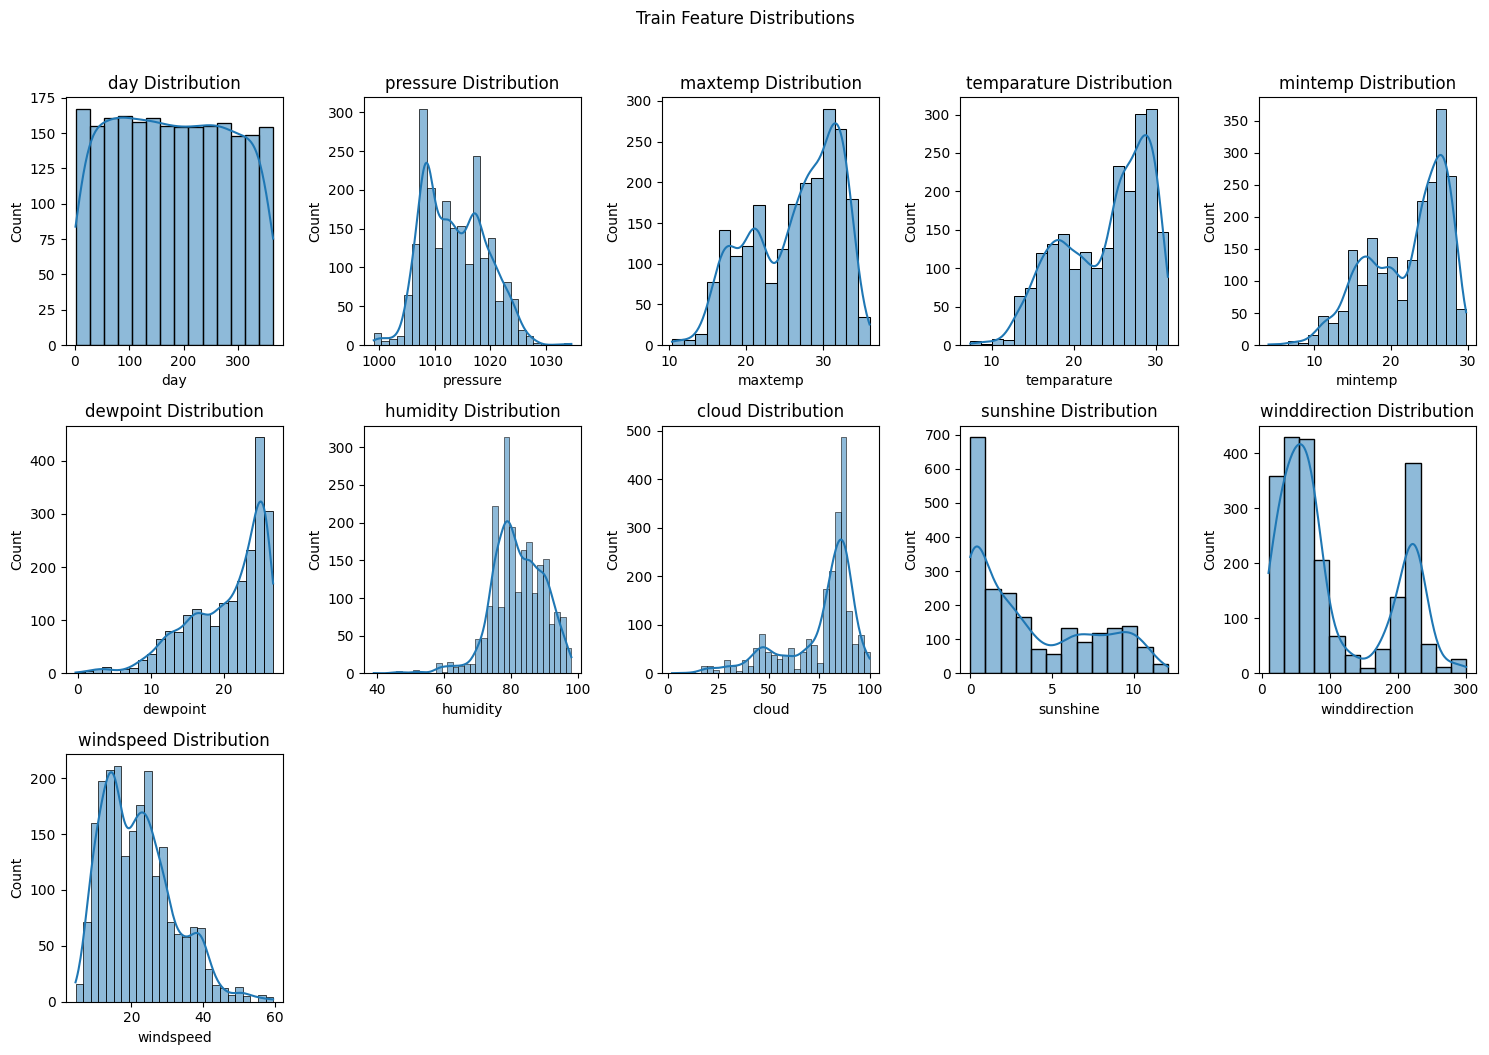

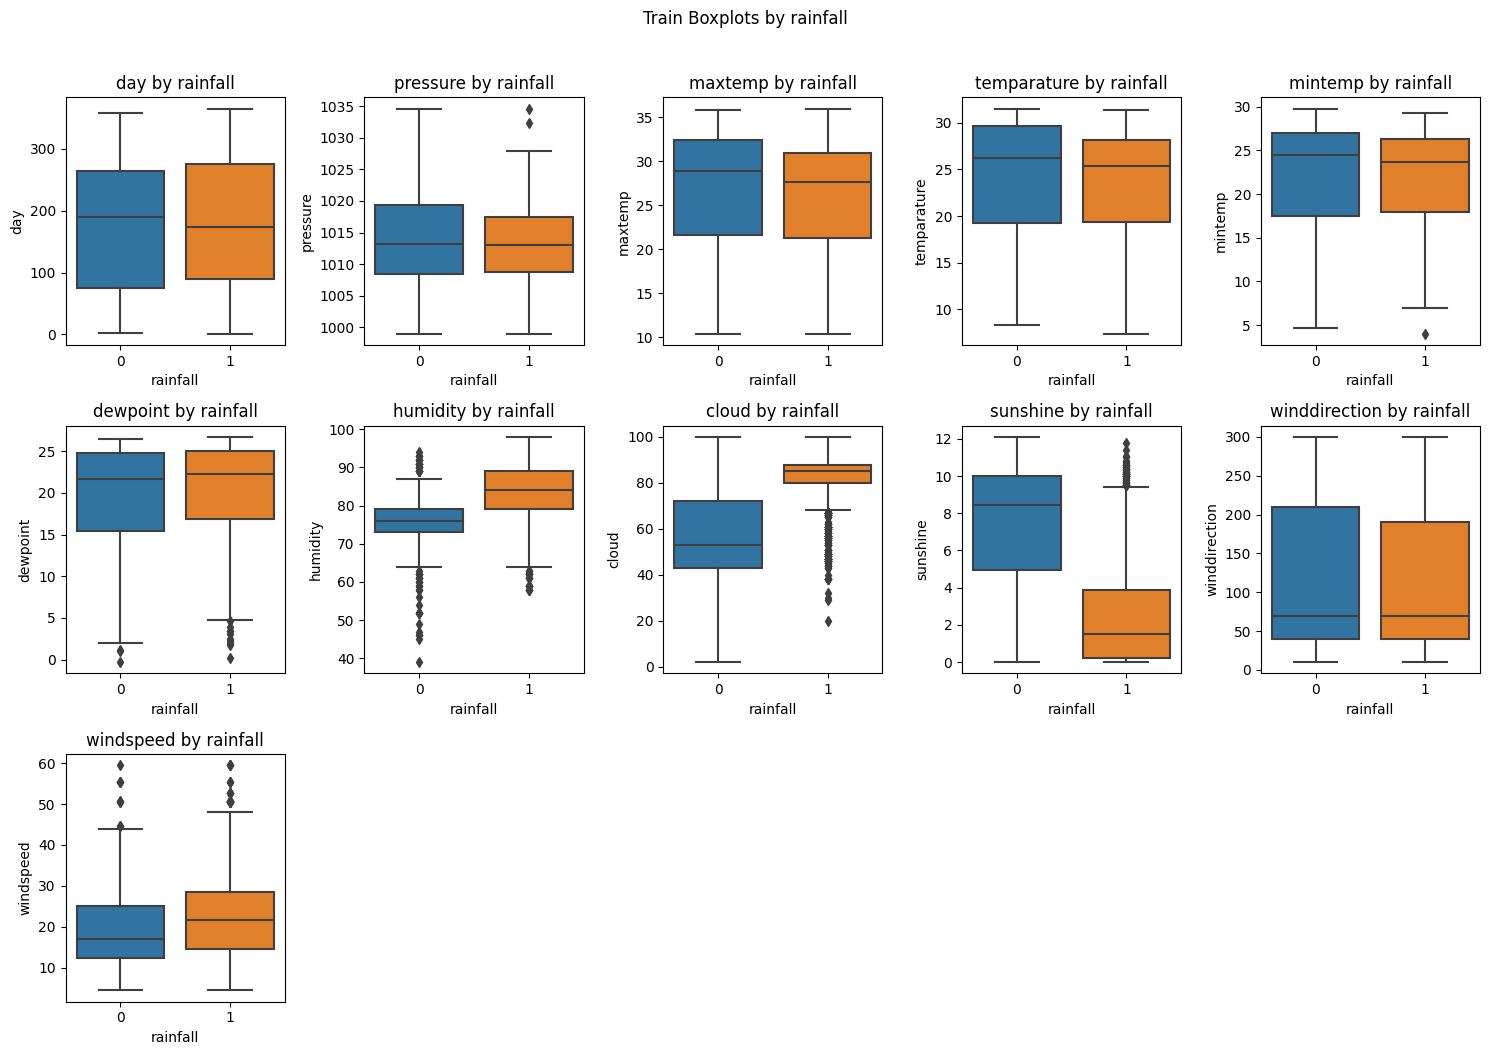

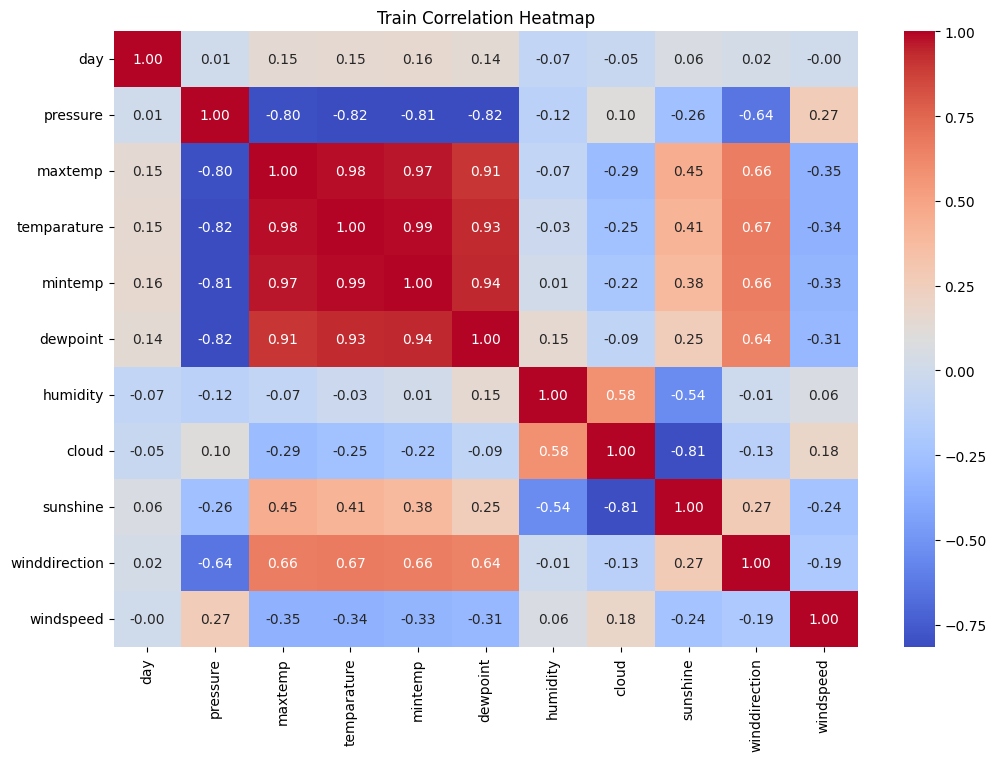

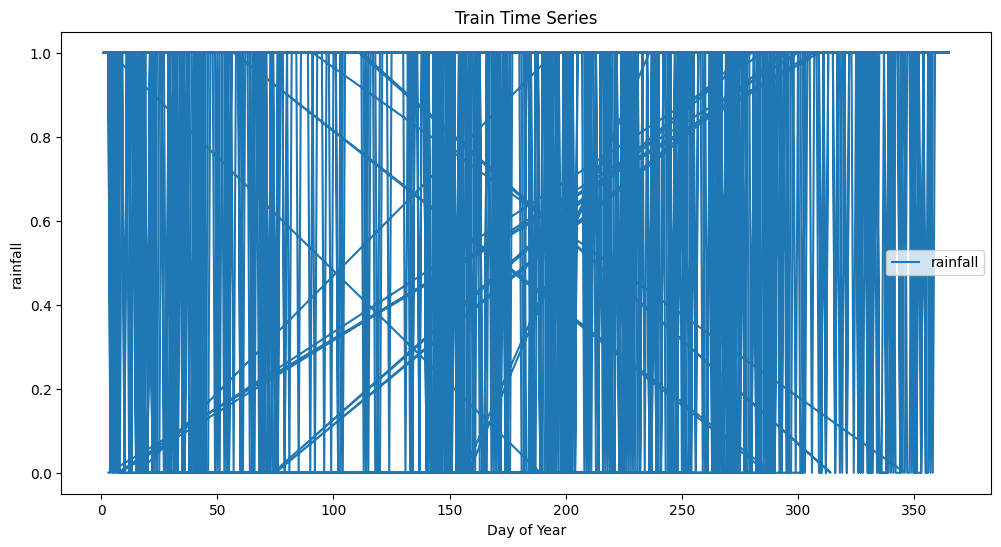

In [14]:
# Plot for train_data
plot_data(train_data, plot_type='distribution', features=feature_cols, title_prefix="Train")
plot_data(train_data, plot_type='boxplot', features=feature_cols, target='rainfall', title_prefix="Train")
plot_data(train_data, plot_type='correlation', features=feature_cols, title_prefix="Train")
plot_data(train_data, plot_type='time_series', target='rainfall', title_prefix="Train")

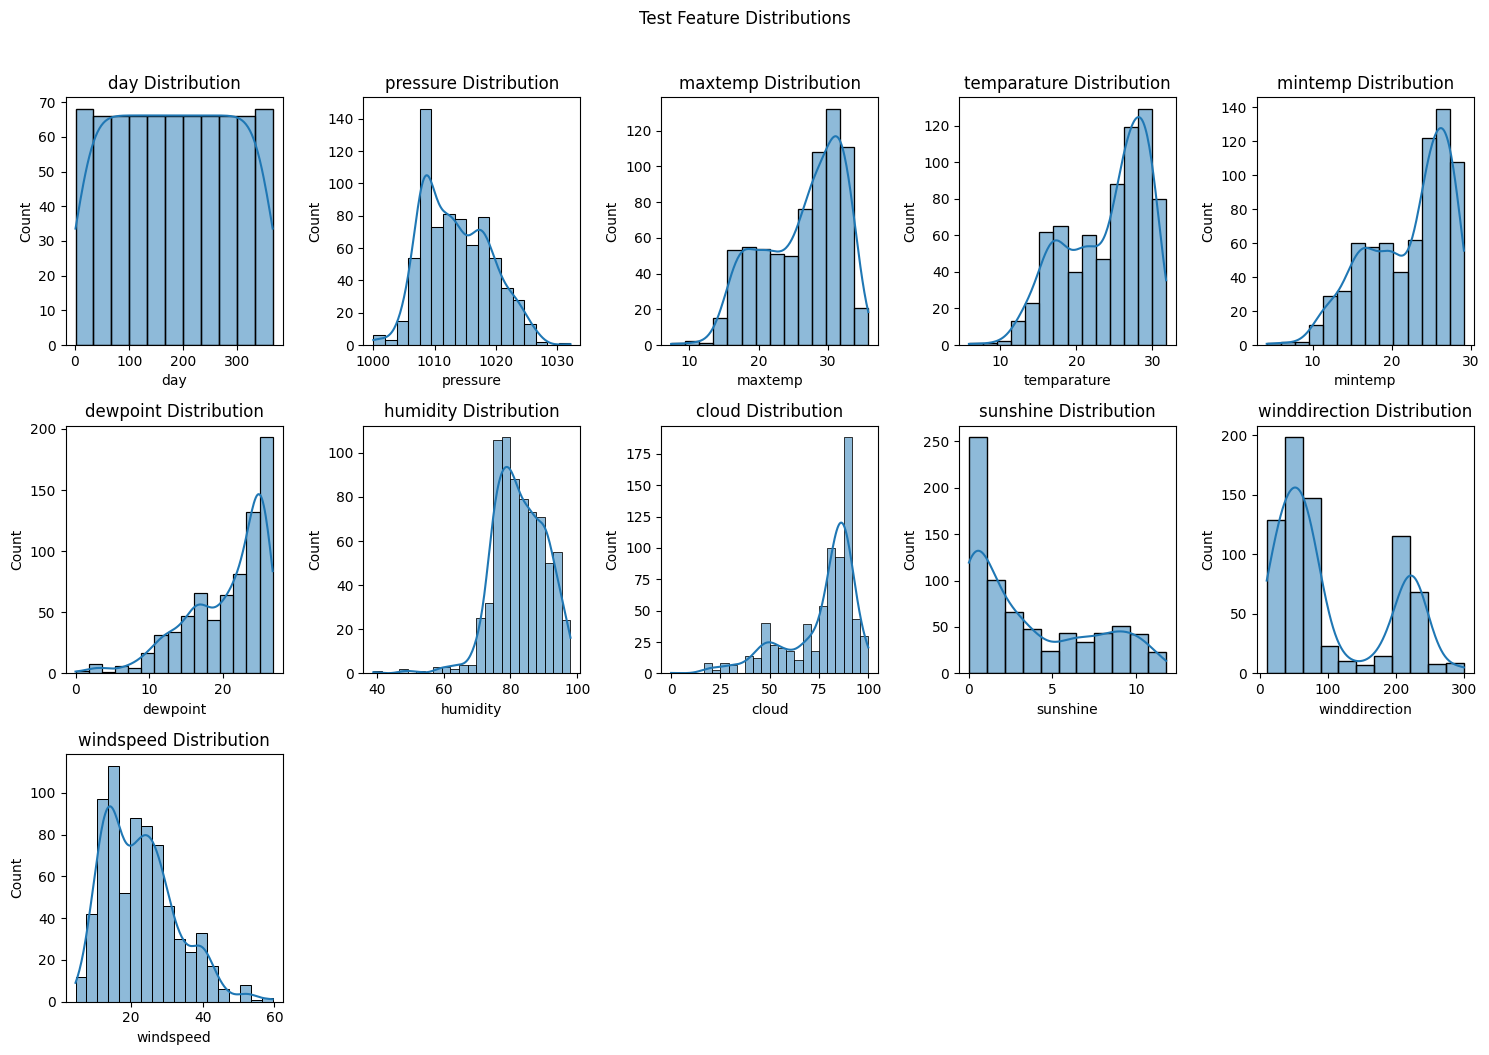

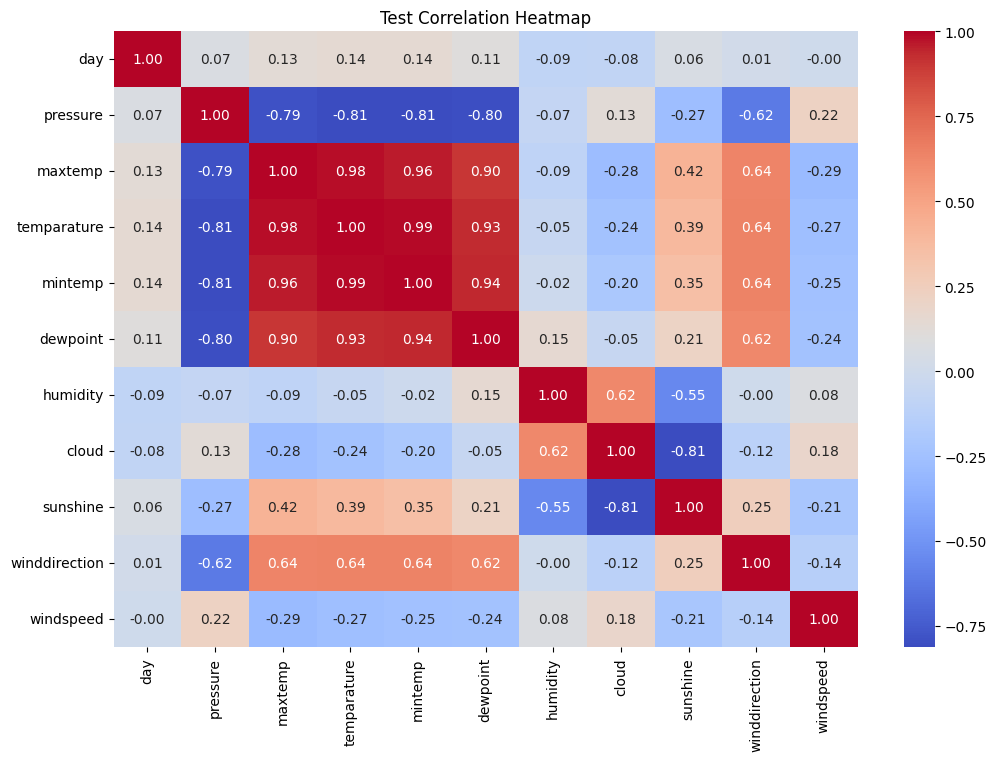

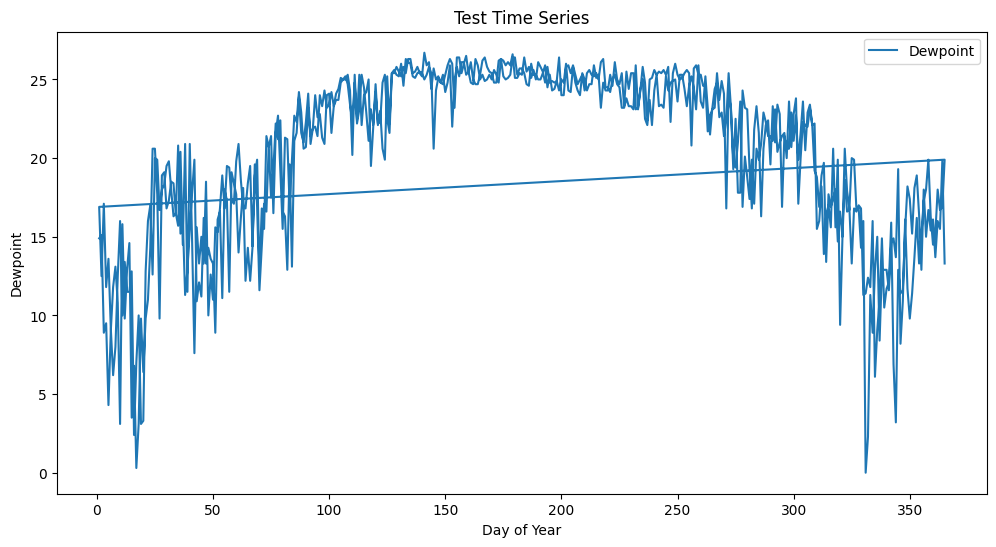

In [15]:
# Plot for test_data
plot_data(test_data, plot_type='distribution', features=feature_cols, title_prefix="Test")
plot_data(test_data, plot_type='correlation', features=feature_cols, title_prefix="Test")
plot_data(test_data, plot_type='time_series', title_prefix="Test")

In [16]:
# ==============================
# Advanced Feature Engineering
# ==============================

# Cyclical encoding for 'day'
train_data['day_sin'] = np.sin(2 * np.pi * train_data['day'] / 365)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['day'] / 365)
test_data['day_sin'] = np.sin(2 * np.pi * test_data['day'] / 365)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['day'] / 365)

# Add lag features
for feature in ['dewpoint', 'humidity', 'cloud', 'sunshine']:
    train_data[f'{feature}_lag1'] = train_data[feature].shift(1)
    test_data[f'{feature}_lag1'] = test_data[feature].shift(1)
    train_data[f'{feature}_lag2'] = train_data[feature].shift(2)
    test_data[f'{feature}_lag2'] = test_data[feature].shift(2)

# Add rolling averages
for feature in ['dewpoint', 'humidity', 'cloud', 'sunshine']:
    train_data[f'{feature}_roll3'] = train_data[feature].rolling(window=3).mean()
    test_data[f'{feature}_roll3'] = test_data[feature].rolling(window=3).mean()
    train_data[f'{feature}_roll7'] = train_data[feature].rolling(window=7).mean()
    test_data[f'{feature}_roll7'] = test_data[feature].rolling(window=7).mean()

In [17]:
# Interaction features
train_data['humidity_cloud'] = train_data['humidity'] * train_data['cloud']
test_data['humidity_cloud'] = test_data['humidity'] * test_data['cloud']
train_data['temp_diff'] = train_data['maxtemp'] - train_data['mintemp']
test_data['temp_diff'] = test_data['maxtemp'] - test_data['mintemp']

# Additional interaction features
train_data['humidity_dewpoint'] = train_data['humidity'] * train_data['dewpoint']
test_data['humidity_dewpoint'] = test_data['humidity'] * test_data['dewpoint']
train_data['cloud_sunshine'] = train_data['cloud'] * train_data['sunshine']
test_data['cloud_sunshine'] = test_data['cloud'] * test_data['sunshine']

In [18]:
# Seasonal feature
def get_season(day):
    if 60 <= day <= 151:
        return 1  # Spring
    elif 152 <= day <= 243:
        return 2  # Summer
    elif 244 <= day <= 334:
        return 3  # Fall
    else:
        return 4  # Winter

In [19]:
train_data['season'] = train_data['day'].apply(get_season)
test_data['season'] = test_data['day'].apply(get_season)

In [20]:
# Fill NaN values
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

In [21]:
# Update feature columns
new_features = [f'{feat}_lag1' for feat in ['dewpoint', 'humidity', 'cloud', 'sunshine']] + \
               [f'{feat}_lag2' for feat in ['dewpoint', 'humidity', 'cloud', 'sunshine']] + \
               [f'{feat}_roll3' for feat in ['dewpoint', 'humidity', 'cloud', 'sunshine']] + \
               [f'{feat}_roll7' for feat in ['dewpoint', 'humidity', 'cloud', 'sunshine']] + \
               ['day_sin', 'day_cos', 'humidity_cloud', 'temp_diff', 'season', 'humidity_dewpoint', 'cloud_sunshine']
feature_cols.extend(new_features)

In [22]:
# Debugging: Print feature_cols after feature engineering
print("\nFeature columns after feature engineering:", feature_cols)


Feature columns after feature engineering: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'dewpoint_lag1', 'humidity_lag1', 'cloud_lag1', 'sunshine_lag1', 'dewpoint_lag2', 'humidity_lag2', 'cloud_lag2', 'sunshine_lag2', 'dewpoint_roll3', 'humidity_roll3', 'cloud_roll3', 'sunshine_roll3', 'dewpoint_roll7', 'humidity_roll7', 'cloud_roll7', 'sunshine_roll7', 'day_sin', 'day_cos', 'humidity_cloud', 'temp_diff', 'season', 'humidity_dewpoint', 'cloud_sunshine']


In [23]:
# Update datasets with new features
X_train = train_data.loc[X_train.index, feature_cols]
X_val = train_data.loc[X_val.index, feature_cols]
X_test = test_data[feature_cols]
X = train_data[feature_cols]
y = train_data['rainfall']

In [24]:
# Debugging: Print features in X_train after updating datasets
print("\nFeatures in X_train after updating datasets:", X_train.columns.tolist())


Features in X_train after updating datasets: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'dewpoint_lag1', 'humidity_lag1', 'cloud_lag1', 'sunshine_lag1', 'dewpoint_lag2', 'humidity_lag2', 'cloud_lag2', 'sunshine_lag2', 'dewpoint_roll3', 'humidity_roll3', 'cloud_roll3', 'sunshine_roll3', 'dewpoint_roll7', 'humidity_roll7', 'cloud_roll7', 'sunshine_roll7', 'day_sin', 'day_cos', 'humidity_cloud', 'temp_diff', 'season', 'humidity_dewpoint', 'cloud_sunshine']


In [25]:
# Handle outliers before scaling
X_train = X_train.clip(lower=X_train.quantile(0.01), upper=X_train.quantile(0.99), axis=1)
X_val = X_val.clip(lower=X_val.quantile(0.01), upper=X_val.quantile(0.99), axis=1)
X_test = X_test.clip(lower=X_test.quantile(0.01), upper=X_test.quantile(0.99), axis=1)
X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)

In [26]:
# Scale features for neural network models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [27]:
print("\nFeatures in X_train after scaling (should match X_train_scaled shape):", X_train.columns.tolist())
print("X_train shape:", X_train.shape)
print("X_train_scaled shape:", X_train_scaled.shape)


Features in X_train after scaling (should match X_train_scaled shape): ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'dewpoint_lag1', 'humidity_lag1', 'cloud_lag1', 'sunshine_lag1', 'dewpoint_lag2', 'humidity_lag2', 'cloud_lag2', 'sunshine_lag2', 'dewpoint_roll3', 'humidity_roll3', 'cloud_roll3', 'sunshine_roll3', 'dewpoint_roll7', 'humidity_roll7', 'cloud_roll7', 'sunshine_roll7', 'day_sin', 'day_cos', 'humidity_cloud', 'temp_diff', 'season', 'humidity_dewpoint', 'cloud_sunshine']
X_train shape: (1752, 34)
X_train_scaled shape: (1752, 34)


In [28]:
# Display all columns with horizontal scrolling
print("\nTrain Data (First 5 Rows, All Columns with Scroll):")
display(HTML('<div style="overflow-x: auto;">' + 
             train_data.head().style.set_caption("Train Data (First 5 Rows, All Columns)")
             .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])
             .format(precision=2).to_html() + 
             '</div>'))


Train Data (First 5 Rows, All Columns with Scroll):


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,day_sin,day_cos,dewpoint_lag1,dewpoint_lag2,humidity_lag1,humidity_lag2,cloud_lag1,cloud_lag2,sunshine_lag1,sunshine_lag2,dewpoint_roll3,dewpoint_roll7,humidity_roll3,humidity_roll7,cloud_roll3,cloud_roll7,sunshine_roll3,sunshine_roll7,humidity_cloud,temp_diff,humidity_dewpoint,cloud_sunshine,season
0,0,1,1017.40,21.20,20.60,19.90,19.40,87.00,88.00,1.10,60.00,17.20,1,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7656.00,1.30,1687.80,96.80,4
1,1,2,1019.50,16.20,16.90,15.80,15.40,95.00,91.00,0.00,50.00,21.90,1,0.03,1.00,19.40,0.00,87.00,0.00,88.00,0.00,1.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8645.00,0.40,1463.00,0.00,4
2,2,3,1024.10,19.40,16.10,14.60,9.30,75.00,47.00,8.30,70.00,18.10,1,0.05,1.00,15.40,19.40,95.00,87.00,91.00,88.00,0.00,1.10,14.70,0.00,85.67,0.00,75.33,0.00,3.13,0.00,3525.00,4.80,697.50,390.10,4
3,3,4,1013.40,18.10,17.80,16.90,16.80,95.00,95.00,0.00,60.00,35.60,1,0.07,1.00,9.30,15.40,75.00,95.00,47.00,91.00,8.30,0.00,13.83,0.00,88.33,0.00,77.67,0.00,2.77,0.00,9025.00,1.20,1596.00,0.00,4
4,4,5,1021.80,21.30,18.40,15.20,9.60,52.00,45.00,3.60,40.00,24.80,0,0.09,1.00,16.80,9.30,95.00,75.00,95.00,47.00,0.00,8.30,11.90,0.00,74.00,0.00,62.33,0.00,3.97,0.00,2340.00,6.10,499.20,162.00,4


In [29]:
# Display all columns with horizontal scrolling
print("\nTest Data (First 5 Rows, All Columns with Scroll):")
display(HTML('<div style="overflow-x: auto;">' + 
             test_data.head().style.set_caption("Test Data (First 5 Rows, All Columns)")
             .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])
             .format(precision=2).to_html() + 
             '</div>'))


Test Data (First 5 Rows, All Columns with Scroll):


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,day_sin,day_cos,dewpoint_lag1,dewpoint_lag2,humidity_lag1,humidity_lag2,cloud_lag1,cloud_lag2,sunshine_lag1,sunshine_lag2,dewpoint_roll3,dewpoint_roll7,humidity_roll3,humidity_roll7,cloud_roll3,cloud_roll7,sunshine_roll3,sunshine_roll7,humidity_cloud,temp_diff,humidity_dewpoint,cloud_sunshine,season
0,2190,1,1019.50,17.50,15.80,12.70,14.90,96.00,99.00,0.00,50.00,24.30,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9504.00,4.80,1430.40,0.00,4
1,2191,2,1016.50,17.50,16.50,15.80,15.10,97.00,99.00,0.00,50.00,35.30,0.03,1.00,14.90,0.00,96.00,0.00,99.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9603.00,1.70,1464.70,0.00,4
2,2192,3,1023.90,11.20,10.40,9.40,8.90,86.00,96.00,0.00,40.00,16.90,0.05,1.00,15.10,14.90,97.00,96.00,99.00,99.00,0.00,0.00,12.97,0.00,93.00,0.00,98.00,0.00,0.00,0.00,8256.00,1.80,765.40,0.00,4
3,2193,4,1022.90,20.60,17.30,15.20,9.50,75.00,45.00,7.10,20.00,50.60,0.07,1.00,8.90,15.10,86.00,97.00,96.00,99.00,0.00,0.00,11.17,0.00,86.00,0.00,80.00,0.00,2.37,0.00,3375.00,5.40,712.50,319.50,4
4,2194,5,1022.20,16.10,13.80,6.40,4.30,68.00,49.00,9.20,20.00,19.40,0.09,1.00,9.50,8.90,75.00,86.00,45.00,96.00,7.10,0.00,7.57,0.00,76.33,0.00,63.33,0.00,5.43,0.00,3332.00,9.70,292.40,450.80,4


In [30]:
# ======================================
# Feature Selection: Remove Highly Correlated Features
# ======================================

# Check for NaN or inf values in X_train
print("\nChecking for NaN or inf values in X_train:")
print("NaN values:", X_train.isna().sum().sum())
print("Inf values:", np.isinf(X_train).sum().sum())

# Replace inf with NaN and fill NaN with 0
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Drop nearly constant features (features with very low standard deviation)
std_threshold = 1e-6  # Adjust this threshold as needed
nearly_constant_features = [col for col in X_train.columns if X_train[col].std() < std_threshold]
print("Nearly constant features to drop (std < 1e-6):", nearly_constant_features)
X_train = X_train.drop(columns=nearly_constant_features)
X_val = X_val.drop(columns=nearly_constant_features)
X_test = X_test.drop(columns=nearly_constant_features)
X = X.drop(columns=nearly_constant_features)
feature_cols = [col for col in feature_cols if col not in nearly_constant_features]

# Debugging: Print features in X_train
print("\nFeatures in X_train before correlation computation:", X_train.columns.tolist())

# Compute correlation matrix
corr_matrix = X_train.corr().abs()

# Debugging: Check for NaN in corr_matrix before filling
print("\nNaN values in corr_matrix before filling:", corr_matrix.isna().sum().sum())
print("Correlation matrix (first 5x5):")
print(corr_matrix.iloc[:5, :5])

# Handle NaN values in the correlation matrix
corr_matrix = corr_matrix.fillna(0)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Debugging: Check for NaN in upper before filling
print("\nNaN values in upper before filling:", upper.isna().sum().sum())
print("Upper triangle (first 5x5):")
print(upper.iloc[:5, :5])

# Handle NaN values in the upper triangle
upper = upper.fillna(0)

# Debugging: Check max correlation for each column
max_corrs = upper.max()
print("\nMax correlation for each feature:")
print(max_corrs[max_corrs > 0.7])

# Find features with correlation greater than 0.85 (lowered threshold)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("\nFeatures to drop due to high correlation (> 0.85):", to_drop)

# Drop highly correlated features
X_train = X_train.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X = X.drop(columns=to_drop)
feature_cols = [col for col in feature_cols if col not in to_drop]

# Check for zero-variance features before scaling
zero_variance_features = [col for col in X_train.columns if X_train[col].std() == 0]
print("\nZero-variance features before scaling:", zero_variance_features)
X_train = X_train.drop(columns=zero_variance_features)
X_val = X_val.drop(columns=zero_variance_features)
X_test = X_test.drop(columns=zero_variance_features)
X = X.drop(columns=zero_variance_features)
feature_cols = [col for col in feature_cols if col not in zero_variance_features]

# Rescale after dropping features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# Check for NaN or inf in scaled data
print("\nChecking for NaN or inf in scaled data:")
print("X_train_scaled NaN:", np.isnan(X_train_scaled).sum())
print("X_train_scaled inf:", np.isinf(X_train_scaled).sum())
print("X_val_scaled NaN:", np.isnan(X_val_scaled).sum())
print("X_val_scaled inf:", np.isinf(X_val_scaled).sum())
print("X_test_scaled NaN:", np.isnan(X_test_scaled).sum())
print("X_test_scaled inf:", np.isinf(X_test_scaled).sum())
print("X_scaled NaN:", np.isnan(X_scaled).sum())
print("X_scaled inf:", np.isinf(X_scaled).sum())

# Replace NaN or inf in scaled data with 0
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0, posinf=0, neginf=0)
X_val_scaled = np.nan_to_num(X_val_scaled, nan=0, posinf=0, neginf=0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0, posinf=0, neginf=0)
X_scaled = np.nan_to_num(X_scaled, nan=0, posinf=0, neginf=0)


Checking for NaN or inf values in X_train:
NaN values: 0
Inf values: 0
Nearly constant features to drop (std < 1e-6): []

Features in X_train before correlation computation: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'dewpoint_lag1', 'humidity_lag1', 'cloud_lag1', 'sunshine_lag1', 'dewpoint_lag2', 'humidity_lag2', 'cloud_lag2', 'sunshine_lag2', 'dewpoint_roll3', 'humidity_roll3', 'cloud_roll3', 'sunshine_roll3', 'dewpoint_roll7', 'humidity_roll7', 'cloud_roll7', 'sunshine_roll7', 'day_sin', 'day_cos', 'humidity_cloud', 'temp_diff', 'season', 'humidity_dewpoint', 'cloud_sunshine']

NaN values in corr_matrix before filling: 0
Correlation matrix (first 5x5):
                  day  pressure   maxtemp  temparature   mintemp
day          1.000000  0.014492  0.130591     0.136250  0.143716
pressure     0.014492  1.000000  0.807117     0.821638  0.820031
maxtemp      0.130591  0.807117  1.000000     0.983

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [31]:
# ======================================
# Define Models and Hyperparameter Grids
# ======================================

# Handle class imbalance for LightGBM
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Apply SMOTE to balance the training data
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"After SMOTE - Positive: {(y_train_smote == 1).sum()}, Negative: {(y_train_smote == 0).sum()}")

# Run a preliminary LightGBM model to get feature importance for selection
print("\n=== Running Preliminary LightGBM for Feature Selection ===")
prelim_model = lgb.LGBMClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    min_split_gain=0.01,
    bagging_fraction=0.8,
    feature_fraction=0.8,
    colsample_bytree=None,
    subsample=None,
    num_leaves=15,
    min_child_samples=5,
    device='gpu',  # Enable GPU for preliminary LightGBM
    gpu_platform_id=0,
    gpu_device_id=0
)
prelim_model.fit(X_train_smote, y_train_smote)

# Get feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': prelim_model.feature_importances_
}).sort_values('importance', ascending=False)

# Select features with importance > 20
selected_features = importance[importance['importance'] > 20]['feature'].tolist()
print("\nSelected Features (importance > 20):")
print(selected_features)

# Update datasets with selected features
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]
X = X[selected_features]
feature_cols = selected_features

# Rescale after feature selection
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# Update X_train_smote with selected features
X_train_smote = X_train_smote[selected_features]

# Dictionary of models and their hyperparameter grids
models = {
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'param_grid': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.3],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'use_scaling': False
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(
            random_state=42,
            scale_pos_weight=scale_pos_weight,
            min_split_gain=0.01,
            bagging_fraction=0.8,
            feature_fraction=0.8,
            colsample_bytree=None,
            subsample=None,
            num_leaves=15,
            min_child_samples=5
        ),
        'param_grid': {
            'max_depth': [7, 10, 15, 20],
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [100, 200, 300, 500],
            'bagging_fraction': [0.8, 1.0],
            'feature_fraction': [0.8, 1.0],
            'min_child_samples': [1, 5, 10],
            'num_leaves': [15, 31, 50, 70]
        },
        'use_scaling': False
    },
    'MLP': {
        'model': MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10),
        'param_grid': {
            'hidden_layer_sizes': [(100,), (100, 50), (100, 50, 25), (200, 100)],
            'learning_rate_init': [0.0001, 0.001, 0.01, 0.05],
            'max_iter': [1000, 2000],
            'alpha': [0.0001, 0.001, 0.01]
        },
        'use_scaling': True
    }
}


Applying SMOTE to balance the training data...
After SMOTE - Positive: 1331, Negative: 1331

=== Running Preliminary LightGBM for Feature Selection ===
[LightGBM] [Info] Number of positive: 1331, number of negative: 1331
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5323
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 22
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 22 dense feature groups (0.06 MB) transferred to GPU in 0.002193 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Selected Features (importance > 20):
['cloud', 'humidity', 'windspeed', 'sunshine', 'pressure', 'humidity_lag1', 'maxtemp', 'c

In [32]:
# ==============================
# Function to Run and Evaluate Models
# ==============================

def run_model(model_name, model_info, X_train, X_val, y_train, y_val, X, y, 
              X_test, use_tuning=False, title_suffix=""):
    print(f"\n=== Running {model_name} ({title_suffix}) ===")
    
    # Determine whether to use scaled data
    if model_info['use_scaling']:
        X_train_data = scaler.fit_transform(X_train)
        X_val_data = scaler.transform(X_val)
        X_test_data = scaler.transform(X_test)
        X_data = scaler.transform(X)
    else:
        X_train_data = X_train
        X_val_data = X_val
        X_test_data = X_test
        X_data = X
    
    # Initialize the model
    model = model_info['model']

    # Configure GPU for XGBoost
    if model_name == 'XGBoost':
        model.set_params(tree_method='gpu_hist', predictor='gpu_predictor')
    
    # Configure GPU for LightGBM
    if model_name == 'LightGBM':
        model.set_params(device='gpu', gpu_platform_id=0, gpu_device_id=0)
    
    # If tuning, perform GridSearchCV
    if use_tuning:
        print(f"Tuning hyperparameters for {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=model_info['param_grid'], 
                                   scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
        grid_search.fit(X_train_data, y_train)
        model = grid_search.best_estimator_
        print(f"Best Parameters ({model_name}):", grid_search.best_params_)
        print(f"Best ROC AUC from GridSearch ({model_name}):", grid_search.best_score_)
    else:
        model.fit(X_train_data, y_train)
    
    # Predict probabilities on validation set
    y_pred = model.predict_proba(X_val_data)[:, 1]
    
    # Check for NaN or inf in validation predictions
    print(f"\nChecking for NaN or inf in {model_name} validation predictions (y_pred):")
    print("NaN values:", np.isnan(y_pred).sum())
    print("Inf values:", np.isinf(y_pred).sum())
    
    # Replace NaN or inf in validation predictions
    y_pred = np.nan_to_num(y_pred, nan=0, posinf=0, neginf=0)
    
    # ROC AUC
    auc = roc_auc_score(y_val, y_pred)
    print(f"{model_name} ({title_suffix}) ROC AUC: {auc:.4f}")
    
    # Plot ROC AUC Curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC AUC Curve for {model_name} ({title_suffix})')
    plt.legend()
    plt.show()
    
    # Feature importance (for XGBoost and LightGBM)
    if model_name in ['XGBoost', 'LightGBM']:
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Check for NaN or inf in feature importance
        print(f"\nChecking for NaN or inf in {model_name} feature importance:")
        print("NaN values in importance:", feature_importance['importance'].isna().sum())
        print("Inf values in importance:", np.isinf(feature_importance['importance']).sum())
        
        # Replace NaN or inf in feature importance
        feature_importance['importance'] = feature_importance['importance'].replace([np.inf, -np.inf], np.nan).fillna(0)
        
        print(f"\nFeature Importance ({model_name} {title_suffix}):")
        print(feature_importance)
        
        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Feature Importance ({model_name} {title_suffix})')
        plt.show()
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_data, y, cv=5, scoring='roc_auc')
    
    # Check for NaN or inf in cross-validation scores
    print(f"\nChecking for NaN or inf in {model_name} cross-validation scores:")
    print("NaN values:", np.isnan(cv_scores).sum())
    print("Inf values:", np.isinf(cv_scores).sum())
    
    # Replace NaN or inf in cross-validation scores
    cv_scores = np.nan_to_num(cv_scores, nan=0, posinf=0, neginf=0)
    
    print(f"Cross-Validation ROC AUC Scores ({model_name} {title_suffix}): {cv_scores}")
    print(f"Mean CV ROC AUC ({model_name} {title_suffix}): {cv_scores.mean():.4f}")
    print(f"Standard Deviation ({model_name} {title_suffix}): {cv_scores.std():.4f}")
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    avg_precision = average_precision_score(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name} ({title_suffix})')
    plt.legend()
    plt.show()
    
    # Prediction Distribution
    plot_data(y_pred, plot_type='pred_dist', title_prefix=f"Validation Set ({model_name} {title_suffix})")
    
    # Predict on test data
    test_preds = model.predict_proba(X_test_data)[:, 1]
    
    # Check for NaN or inf in test predictions
    print(f"\nChecking for NaN or inf in {model_name} test predictions (test_preds):")
    print("NaN values:", np.isnan(test_preds).sum())
    print("Inf values:", np.isinf(test_preds).sum())
    
    # Replace NaN or inf in test predictions
    test_preds = np.nan_to_num(test_preds, nan=0, posinf=0, neginf=0)
    
    return model, y_pred, test_preds


=== Running XGBoost (Default) ===

Checking for NaN or inf in XGBoost validation predictions (y_pred):
NaN values: 0
Inf values: 0
XGBoost (Default) ROC AUC: 0.8351


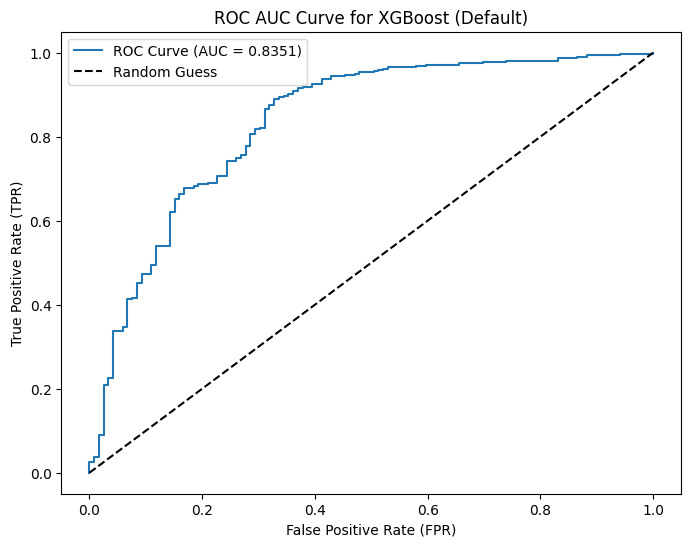


Checking for NaN or inf in XGBoost feature importance:
NaN values in importance: 0
Inf values in importance: 0

Feature Importance (XGBoost Default):
           feature  importance
0            cloud    0.394582
1         humidity    0.055975
9              day    0.039553
6          maxtemp    0.037176
4         pressure    0.036646
2        windspeed    0.034164
3         sunshine    0.033828
10   winddirection    0.032382
12         day_sin    0.031135
18      cloud_lag2    0.030042
19  humidity_roll3    0.029870
16   humidity_lag2    0.027876
5    humidity_lag1    0.027218
14  humidity_roll7    0.026351
17      cloud_lag1    0.025509
8   sunshine_roll3    0.024960
20     cloud_roll3    0.023564
11       temp_diff    0.023198
7      cloud_roll7    0.022912
13   sunshine_lag1    0.021790
15   sunshine_lag2    0.021268


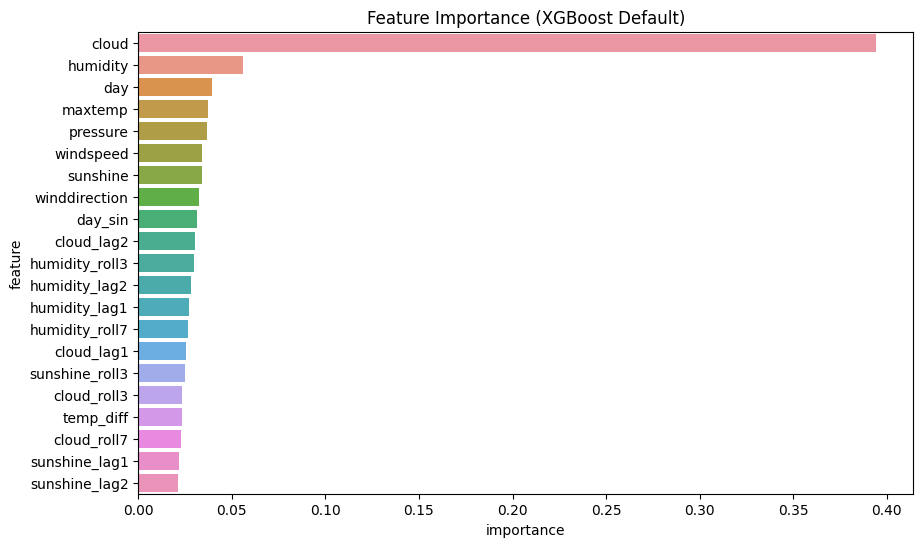


Checking for NaN or inf in XGBoost cross-validation scores:
NaN values: 0
Inf values: 0
Cross-Validation ROC AUC Scores (XGBoost Default): [0.83911336 0.87906846 0.89124579 0.86301908 0.86470258]
Mean CV ROC AUC (XGBoost Default): 0.8674
Standard Deviation (XGBoost Default): 0.0175


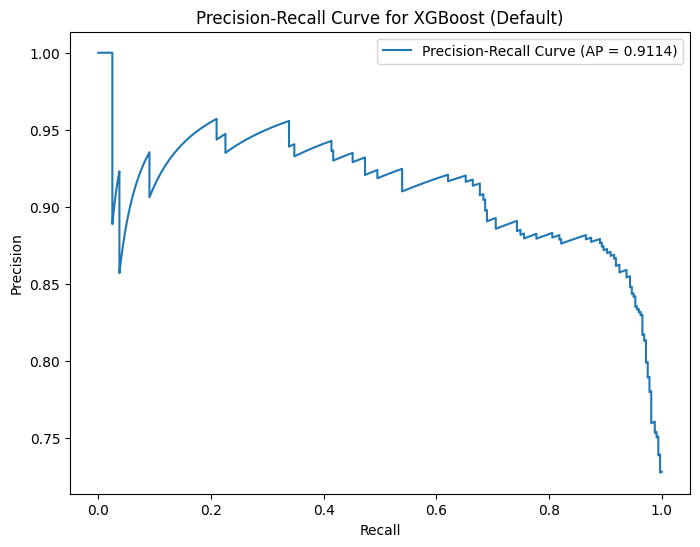

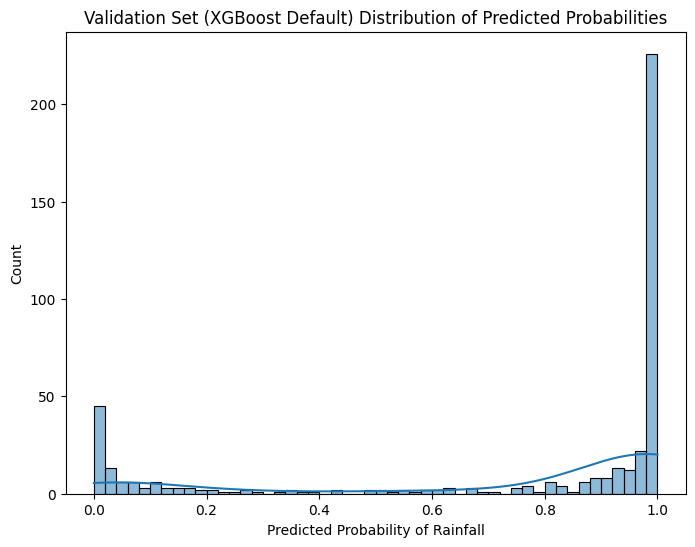


Checking for NaN or inf in XGBoost test predictions (test_preds):
NaN values: 0
Inf values: 0

=== Running XGBoost (Tuned) ===
Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters (XGBoost): {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Best ROC AUC from GridSearch (XGBoost): 0.9710150386526424

Checking for NaN or inf in XGBoost validation predictions (y_pred):
NaN values: 0
Inf values: 0
XGBoost (Tuned) ROC AUC: 0.8251


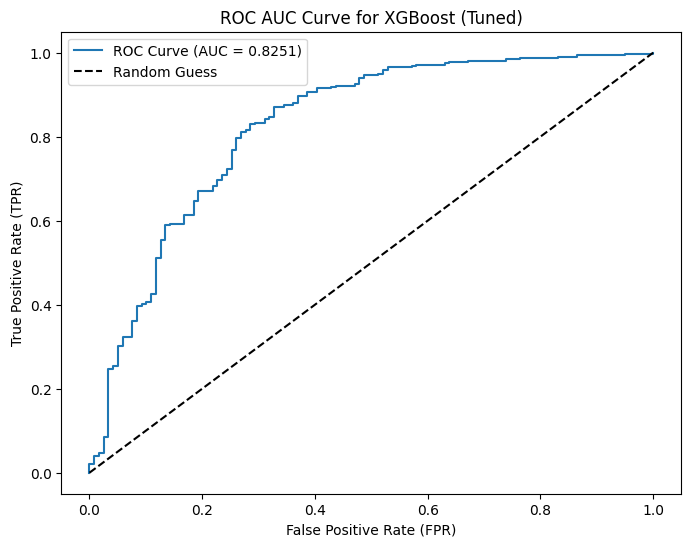


Checking for NaN or inf in XGBoost feature importance:
NaN values in importance: 0
Inf values in importance: 0

Feature Importance (XGBoost Tuned):
           feature  importance
0            cloud    0.318951
1         humidity    0.101814
3         sunshine    0.053101
6          maxtemp    0.044080
20     cloud_roll3    0.037963
10   winddirection    0.036856
12         day_sin    0.034626
9              day    0.031055
2        windspeed    0.030848
4         pressure    0.029614
8   sunshine_roll3    0.029224
7      cloud_roll7    0.027241
14  humidity_roll7    0.026933
15   sunshine_lag2    0.026605
18      cloud_lag2    0.026055
17      cloud_lag1    0.025283
19  humidity_roll3    0.025002
13   sunshine_lag1    0.024776
16   humidity_lag2    0.023900
11       temp_diff    0.023322
5    humidity_lag1    0.022749


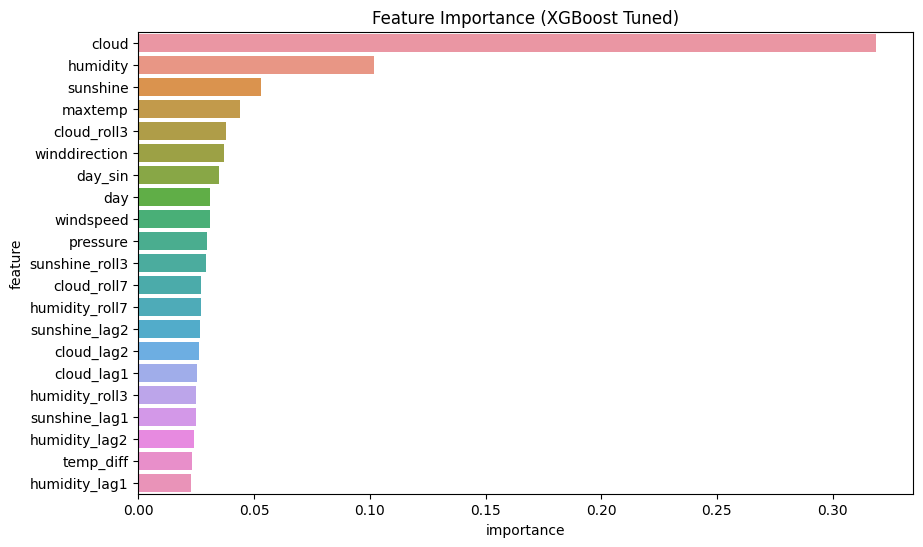


Checking for NaN or inf in XGBoost cross-validation scores:
NaN values: 0
Inf values: 0
Cross-Validation ROC AUC Scores (XGBoost Tuned): [0.84222783 0.87609428 0.89772727 0.85488215 0.84492144]
Mean CV ROC AUC (XGBoost Tuned): 0.8632
Standard Deviation (XGBoost Tuned): 0.0210


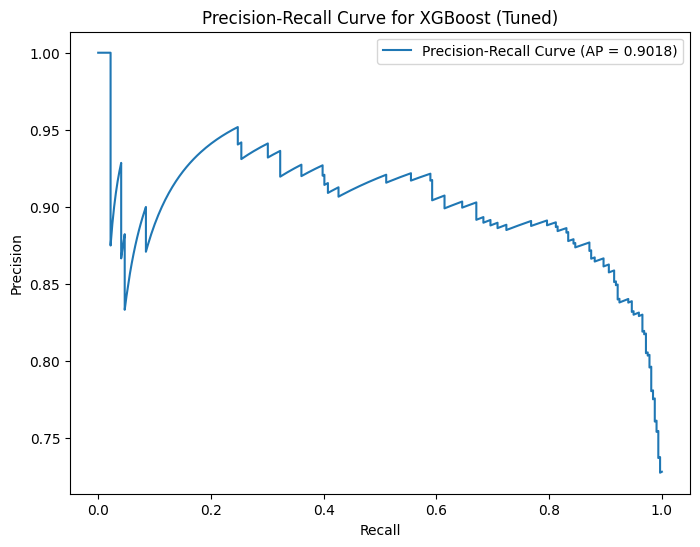

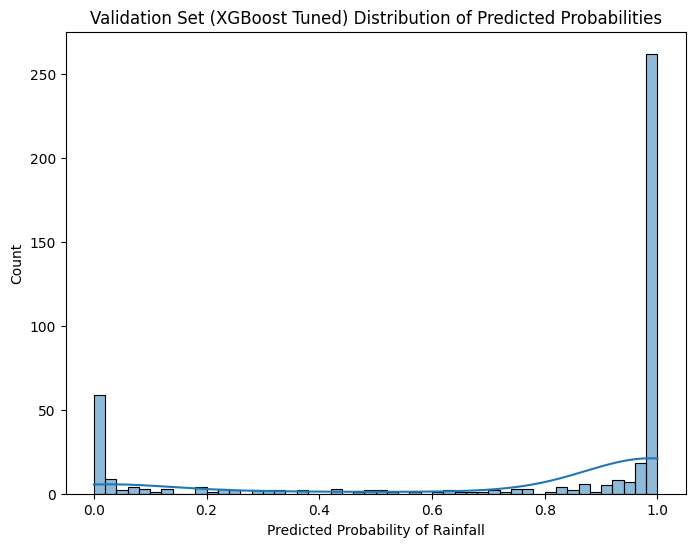


Checking for NaN or inf in XGBoost test predictions (test_preds):
NaN values: 0
Inf values: 0

=== Running LightGBM (Default) ===
[LightGBM] [Info] Number of positive: 1331, number of negative: 1331
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5318
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 21
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.06 MB) transferred to GPU in 0.000768 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Checking for NaN or inf in LightGBM validation predictions (y_pred):
NaN values: 0
Inf values: 0
LightGBM (Default) ROC AUC: 0.8501


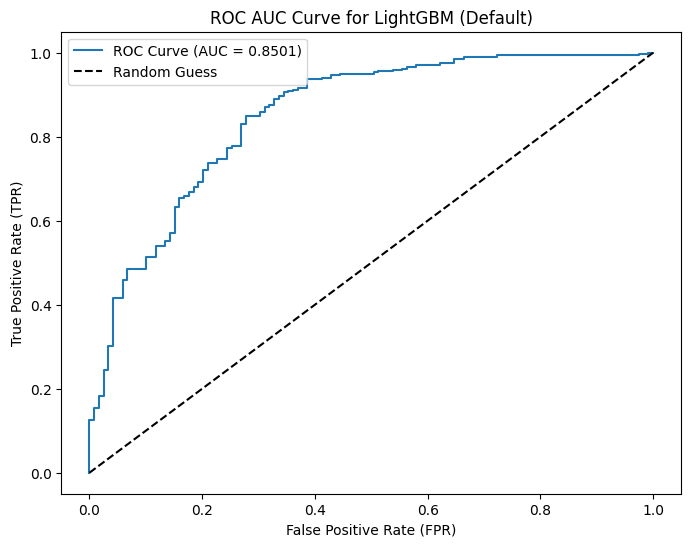


Checking for NaN or inf in LightGBM feature importance:
NaN values in importance: 0
Inf values in importance: 0

Feature Importance (LightGBM Default):
           feature  importance
0            cloud         139
1         humidity          92
3         sunshine          86
2        windspeed          83
4         pressure          78
6          maxtemp          78
7      cloud_roll7          75
12         day_sin          73
5    humidity_lag1          71
11       temp_diff          66
10   winddirection          57
9              day          57
16   humidity_lag2          55
15   sunshine_lag2          54
8   sunshine_roll3          53
13   sunshine_lag1          51
14  humidity_roll7          50
17      cloud_lag1          50
19  humidity_roll3          48
18      cloud_lag2          42
20     cloud_roll3          42


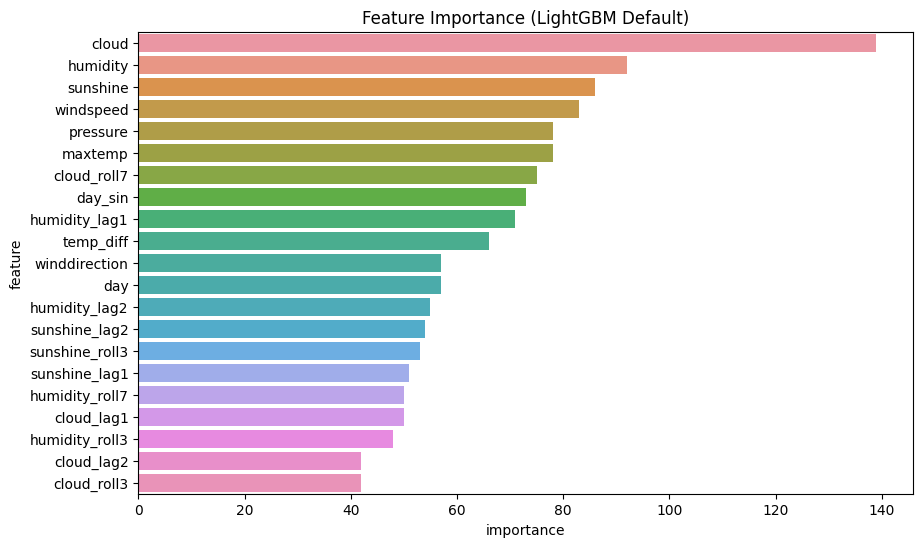

[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2681
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 21
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.04 MB) transferred to GPU in 0.000776 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.753425 -> initscore=1.116961
[LightGBM] [Info] Start training from score 1.116961
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 1752, number of used fea

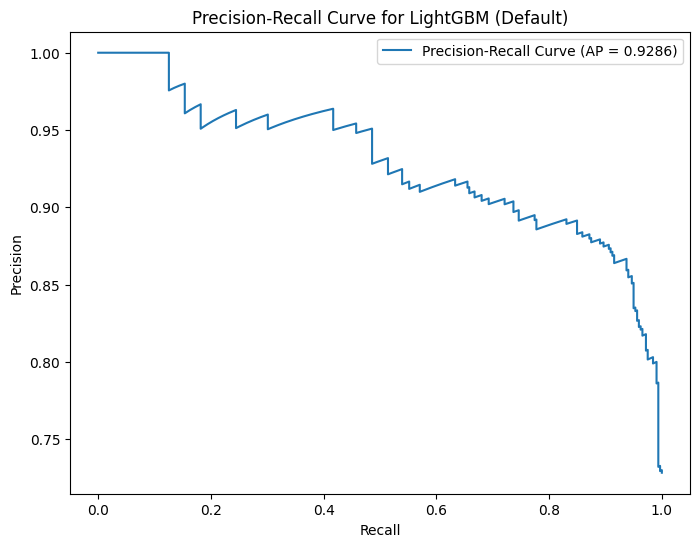

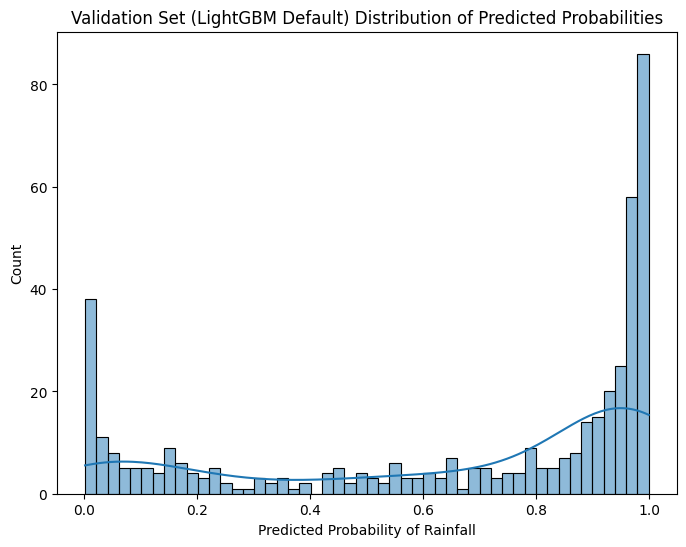


Checking for NaN or inf in LightGBM test predictions (test_preds):
NaN values: 0
Inf values: 0

Skipping GridSearchCV for LightGBM to avoid long runtime. Using default parameters.

=== Running MLP (Default) ===

Checking for NaN or inf in MLP validation predictions (y_pred):
NaN values: 0
Inf values: 0
MLP (Default) ROC AUC: 0.8525


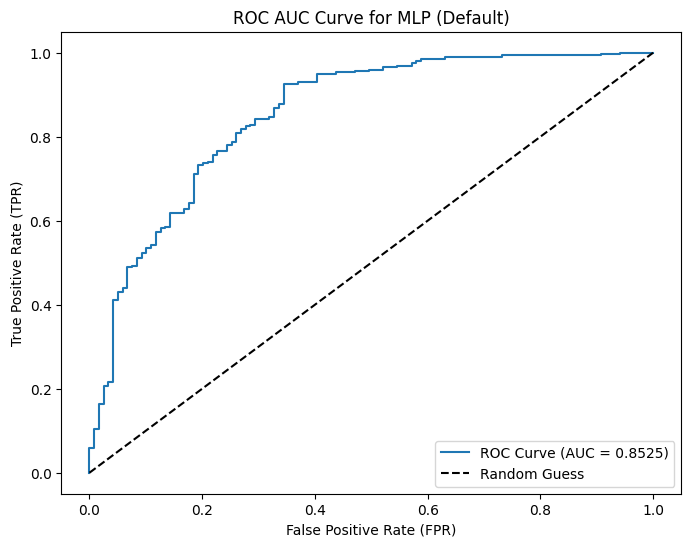


Checking for NaN or inf in MLP cross-validation scores:
NaN values: 0
Inf values: 0
Cross-Validation ROC AUC Scores (MLP Default): [0.86285073 0.90328283 0.90120651 0.89031987 0.87724467]
Mean CV ROC AUC (MLP Default): 0.8870
Standard Deviation (MLP Default): 0.0152


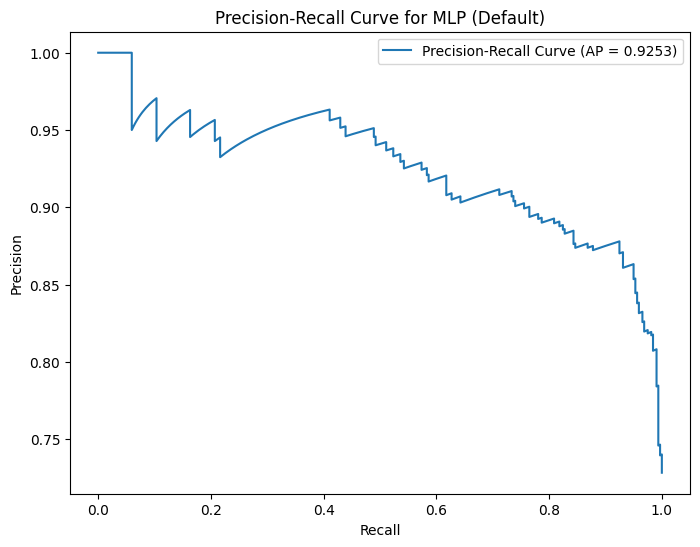

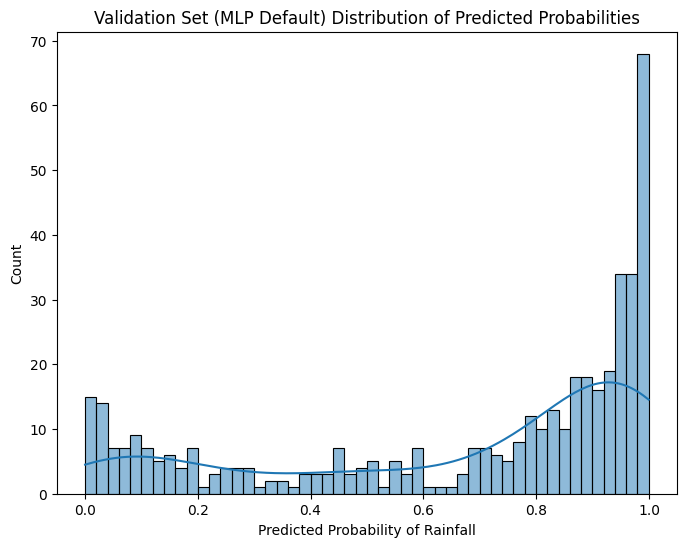


Checking for NaN or inf in MLP test predictions (test_preds):
NaN values: 0
Inf values: 0

=== Running MLP (Tuned) ===
Tuning hyperparameters for MLP...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters (MLP): {'alpha': 0.01, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.01, 'max_iter': 1000}
Best ROC AUC from GridSearch (MLP): 0.9498653387714449

Checking for NaN or inf in MLP validation predictions (y_pred):
NaN values: 0
Inf values: 0
MLP (Tuned) ROC AUC: 0.7746


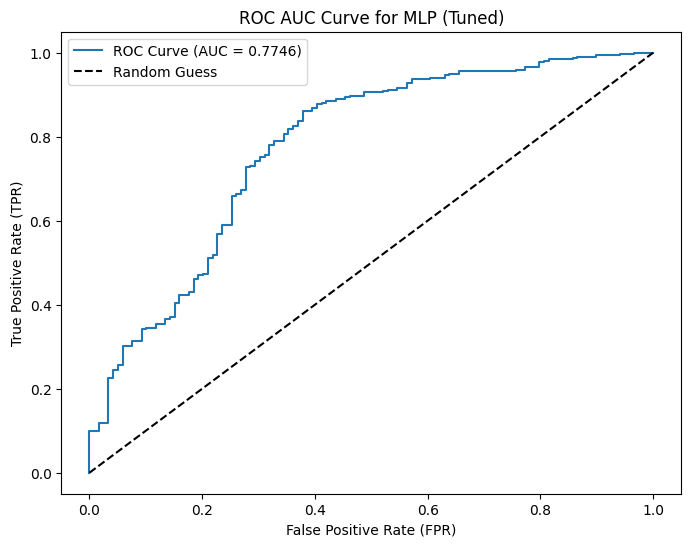


Checking for NaN or inf in MLP cross-validation scores:
NaN values: 0
Inf values: 0
Cross-Validation ROC AUC Scores (MLP Tuned): [0.85805275 0.90070146 0.90861392 0.88644781 0.85611672]
Mean CV ROC AUC (MLP Tuned): 0.8820
Standard Deviation (MLP Tuned): 0.0215


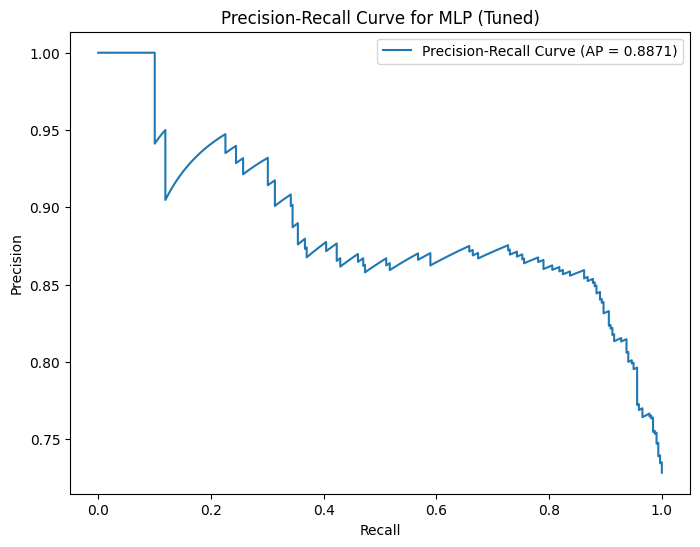

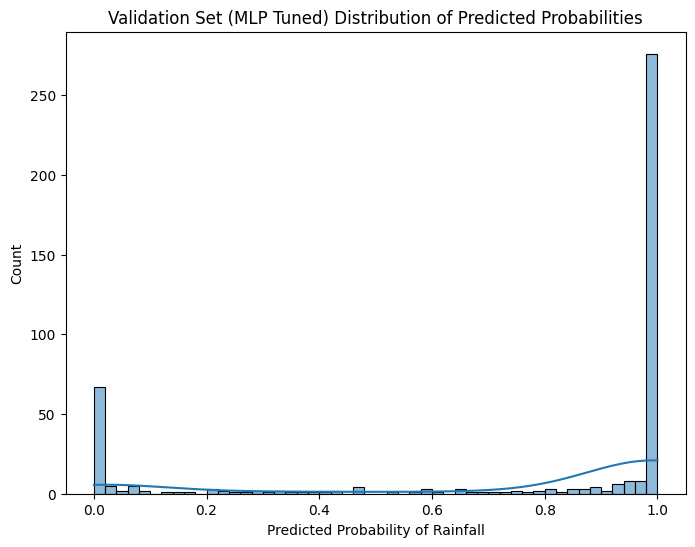


Checking for NaN or inf in MLP test predictions (test_preds):
NaN values: 0
Inf values: 0


In [33]:
# ==============================
# Run Models (Default and Tuned)
# ==============================

val_predictions = {'default': {}, 'tuned': {}}
test_predictions = {'default': {}, 'tuned': {}}
trained_models = {'default': {}, 'tuned': {}}

# Run each model (default and tuned)
for model_name, model_info in models.items():
    # Run default model
    model_default, y_pred_default, test_preds_default = run_model(
        model_name, model_info, X_train_smote, X_val, y_train_smote, y_val, X, y, X_test,
        use_tuning=False, title_suffix="Default"
    )
    val_predictions['default'][model_name] = y_pred_default
    test_predictions['default'][model_name] = test_preds_default
    trained_models['default'][model_name] = model_default
    
    # Run tuned model (skip LightGBM tuning)
    if model_name != 'LightGBM':  # Skip tuning for LightGBM
        model_tuned, y_pred_tuned, test_preds_tuned = run_model(
            model_name, model_info, X_train_smote, X_val, y_train_smote, y_val, X, y, X_test,
            use_tuning=True, title_suffix="Tuned"
        )
        val_predictions['tuned'][model_name] = y_pred_tuned
        test_predictions['tuned'][model_name] = test_preds_tuned
        trained_models['tuned'][model_name] = model_tuned
    else:
        # For LightGBM, use the default model as the "tuned" model (no tuning)
        trained_models['tuned'][model_name] = trained_models['default'][model_name]
        val_predictions['tuned'][model_name] = val_predictions['default'][model_name]
        test_predictions['tuned'][model_name] = test_predictions['default'][model_name]
        print(f"\nSkipping GridSearchCV for LightGBM to avoid long runtime. Using default parameters.")

In [34]:
# ==============================
# Feature Selection (Post-Training)
# ==============================

# Select top 20 features based on LightGBM default model's feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': trained_models['default']['LightGBM'].feature_importances_
}).sort_values('importance', ascending=False)
top_features = importance['feature'].head(20).tolist()
print("\nSelected Top Features (Post-Training):")
print(top_features)

# Update datasets with selected features
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]
X = X[top_features]

# Update X_train_smote with selected features
X_train_smote = X_train_smote[top_features]

# Rescale after feature selection
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# Retrain tuned models with selected features
for model_name in ['XGBoost', 'LightGBM']:
    print(f"\nRetraining {model_name} with selected features...")
    model_info = models[model_name]
    if model_info['use_scaling']:
        X_train_data = X_train_scaled
        X_val_data = X_val_scaled
        X_test_data = X_test_scaled
        X_data = X_scaled
    else:
        X_train_data = X_train
        X_val_data = X_val
        X_test_data = X_test
        X_data = X
    
    if model_name == 'LightGBM':
        # Get the current parameters from the trained model
        params = trained_models['tuned'][model_name].get_params()
        # Update with the parameters we want to enforce
        params.update({
            'random_state': 42,
            'scale_pos_weight': scale_pos_weight,
            'min_split_gain': 0.1,
            'bagging_fraction': 0.8,
            'feature_fraction': 0.8,
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0
        })
        model = lgb.LGBMClassifier(**params)
    else:
        # For XGBoost, avoid passing duplicate parameters
        params = trained_models['tuned'][model_name].get_params()
        if 'tree_method' not in params or params['tree_method'] != 'gpu_hist':
            params['tree_method'] = 'gpu_hist'
        if 'predictor' not in params or params['predictor'] != 'gpu_predictor':
            params['predictor'] = 'gpu_predictor'
        model = model_info['model'].set_params(**params)
    
    model.fit(X_train_data, y_train)
    trained_models['tuned'][model_name] = model


Selected Top Features (Post-Training):
['cloud', 'humidity', 'sunshine', 'windspeed', 'pressure', 'maxtemp', 'cloud_roll7', 'day_sin', 'humidity_lag1', 'temp_diff', 'winddirection', 'day', 'humidity_lag2', 'sunshine_lag2', 'sunshine_roll3', 'sunshine_lag1', 'humidity_roll7', 'cloud_lag1', 'humidity_roll3', 'cloud_lag2']

Retraining XGBoost with selected features...

Retraining LightGBM with selected features...
[LightGBM] [Info] Number of positive: 1331, number of negative: 421
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 20
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (0.03 MB) trans

In [35]:
# Check for NaN or inf in test_data['id']
print("\nChecking for NaN or inf in test_data['id']:")
print("NaN values:", test_data['id'].isna().sum())
print("Inf values:", np.isinf(test_data['id']).sum())

# Replace NaN or inf in test_data['id']
test_data['id'] = test_data['id'].replace([np.inf, -np.inf], np.nan).fillna(0)


Checking for NaN or inf in test_data['id']:
NaN values: 0
Inf values: 0



=== Creating Stacking Ensemble ===
[LightGBM] [Info] Number of positive: 1331, number of negative: 1331
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5066
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 20
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (0.05 MB) transferred to GPU in 0.000813 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1064, number of negative: 1065
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 20
[Ligh

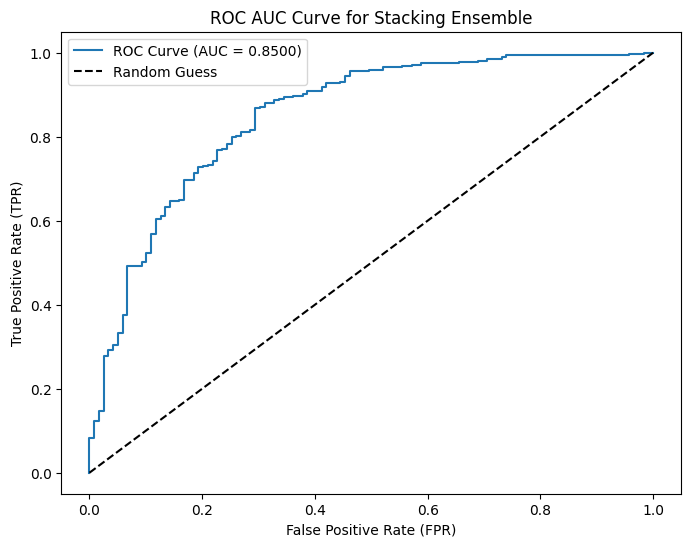

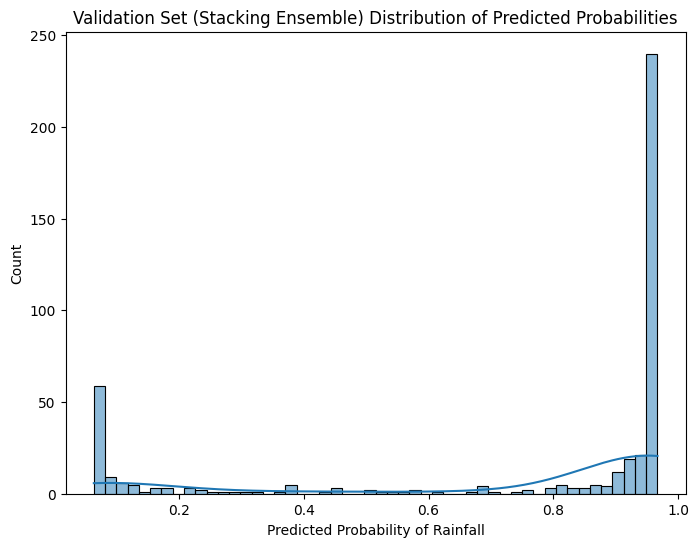


Checking for NaN or inf in stacking test predictions (test_preds_stack):
NaN values: 0
Inf values: 0

Checking for NaN or inf in submission_stack:
NaN values: id          0
rainfall    0
dtype: int64
Inf values: id          0
rainfall    0
dtype: int64

Stacking ensemble submission saved as 'submission_stack.csv'


In [36]:
# ==============================
# Stacking Ensemble
# ==============================

print("\n=== Creating Stacking Ensemble ===")
lightgbm_params = trained_models['tuned']['LightGBM'].get_params()
lightgbm_params.update({
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight,
    'min_split_gain': 0.01,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'colsample_bytree': None,
    'subsample': None,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

base_models = [
    ('xgboost', trained_models['tuned']['XGBoost'].set_params(tree_method='gpu_hist', predictor='gpu_predictor')),
    ('lightgbm', lgb.LGBMClassifier(**lightgbm_params))
]
meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train_smote, y_train_smote)

# Evaluate Stacking Model
y_pred_stack = stacking_model.predict_proba(X_val)[:, 1]

# Check for NaN or inf in stacking validation predictions
print("\nChecking for NaN or inf in stacking validation predictions (y_pred_stack):")
print("NaN values:", np.isnan(y_pred_stack).sum())
print("Inf values:", np.isinf(y_pred_stack).sum())

# Replace NaN or inf in stacking validation predictions
y_pred_stack = np.nan_to_num(y_pred_stack, nan=0, posinf=0, neginf=0)

stack_auc = roc_auc_score(y_val, y_pred_stack)
print(f"Stacking ROC AUC: {stack_auc:.4f}")

# Plot ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_stack)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {stack_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC AUC Curve for Stacking Ensemble')
plt.legend()
plt.show()

# Prediction Distribution
plot_data(y_pred_stack, plot_type='pred_dist', title_prefix="Validation Set (Stacking Ensemble)")

# Predict on test set
test_preds_stack = stacking_model.predict_proba(X_test)[:, 1]

# Check for NaN or inf in stacking test predictions
print("\nChecking for NaN or inf in stacking test predictions (test_preds_stack):")
print("NaN values:", np.isnan(test_preds_stack).sum())
print("Inf values:", np.isinf(test_preds_stack).sum())

# Replace NaN or inf in stacking test predictions
test_preds_stack = np.nan_to_num(test_preds_stack, nan=0, posinf=0, neginf=0)

# Create submission
submission_stack = pd.DataFrame({
    'id': test_data['id'],
    'rainfall': test_preds_stack
})

# Check for NaN or inf in submission_stack
print("\nChecking for NaN or inf in submission_stack:")
print("NaN values:", submission_stack.isna().sum())
print("Inf values:", np.isinf(submission_stack).sum())

# Replace NaN or inf in submission_stack
submission_stack = submission_stack.fillna(0)
submission_stack = submission_stack.replace([np.inf, -np.inf], 0)

submission_stack.to_csv('submission_stack.csv', index=False)
print("\nStacking ensemble submission saved as 'submission_stack.csv'")

In [37]:
# ==============================
# Threshold Optimization (Optional)
# ==============================

print("\n=== Optimizing Threshold ===")
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for thresh in thresholds:
    y_pred_binary = (y_pred_stack > thresh).astype(int)
    f1 = f1_score(y_val, y_pred_binary)
    f1_scores.append(f1)

# Check for NaN or inf in f1_scores
print("\nChecking for NaN or inf in f1_scores:")
print("NaN values:", np.isnan(f1_scores).sum())
print("Inf values:", np.isinf(f1_scores).sum())

# Replace NaN or inf in f1_scores
f1_scores = np.nan_to_num(f1_scores, nan=0, posinf=0, neginf=0)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold:.2f}")

# Apply threshold to test predictions
test_preds_binary = (test_preds_stack > optimal_threshold).astype(int)

# Create submission
submission_binary = pd.DataFrame({
    'id': test_data['id'],
    'rainfall': test_preds_binary
})

# Check for NaN or inf in submission_binary
print("\nChecking for NaN or inf in submission_binary:")
print("NaN values:", submission_binary.isna().sum())
print("Inf values:", np.isinf(submission_binary).sum())

# Replace NaN or inf in submission_binary
submission_binary = submission_binary.fillna(0)
submission_binary = submission_binary.replace([np.inf, -np.inf], 0)

submission_binary.to_csv('submission_binary.csv', index=False)
print("Binary submission saved as 'submission_binary.csv'")


=== Optimizing Threshold ===

Checking for NaN or inf in f1_scores:
NaN values: 0
Inf values: 0
Optimal threshold: 0.13

Checking for NaN or inf in submission_binary:
NaN values: id          0
rainfall    0
dtype: int64
Inf values: id          0
rainfall    0
dtype: int64
Binary submission saved as 'submission_binary.csv'


In [38]:
# ==============================
# Calibrated Model (Optional)
# ==============================

# Calibrate the tuned XGBoost model
calibrated_model = CalibratedClassifierCV(
    trained_models['tuned']['XGBoost'].set_params(tree_method='gpu_hist', predictor='gpu_predictor'),
    method='sigmoid',
    cv=5
)
calibrated_model.fit(X_train_smote, y_train_smote)

# Predict calibrated probabilities
test_preds_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Check for NaN or inf in calibrated test predictions
print("\nChecking for NaN or inf in calibrated test predictions (test_preds_calibrated):")
print("NaN values:", np.isnan(test_preds_calibrated).sum())
print("Inf values:", np.isinf(test_preds_calibrated).sum())

# Replace NaN or inf in calibrated test predictions
test_preds_calibrated = np.nan_to_num(test_preds_calibrated, nan=0, posinf=0, neginf=0)

# Create submission file for calibrated model
submission_calibrated = pd.DataFrame({
    'id': test_data['id'],
    'rainfall': test_preds_calibrated
})


Checking for NaN or inf in calibrated test predictions (test_preds_calibrated):
NaN values: 0
Inf values: 0


In [39]:
# Check for NaN or inf in submission_calibrated
print("\nChecking for NaN or inf in submission_calibrated:")
print("NaN values:", submission_calibrated.isna().sum())
print("Inf values:", np.isinf(submission_calibrated).sum())

# Replace NaN or inf in submission_calibrated
submission_calibrated = submission_calibrated.fillna(0)
submission_calibrated = submission_calibrated.replace([np.inf, -np.inf], 0)

submission_calibrated.to_csv('submission_calibrated.csv', index=False)
print("Calibrated submission file created: submission_calibrated.csv")


Checking for NaN or inf in submission_calibrated:
NaN values: id          0
rainfall    0
dtype: int64
Inf values: id          0
rainfall    0
dtype: int64
Calibrated submission file created: submission_calibrated.csv



=== Visualizing Submission Predictions ===


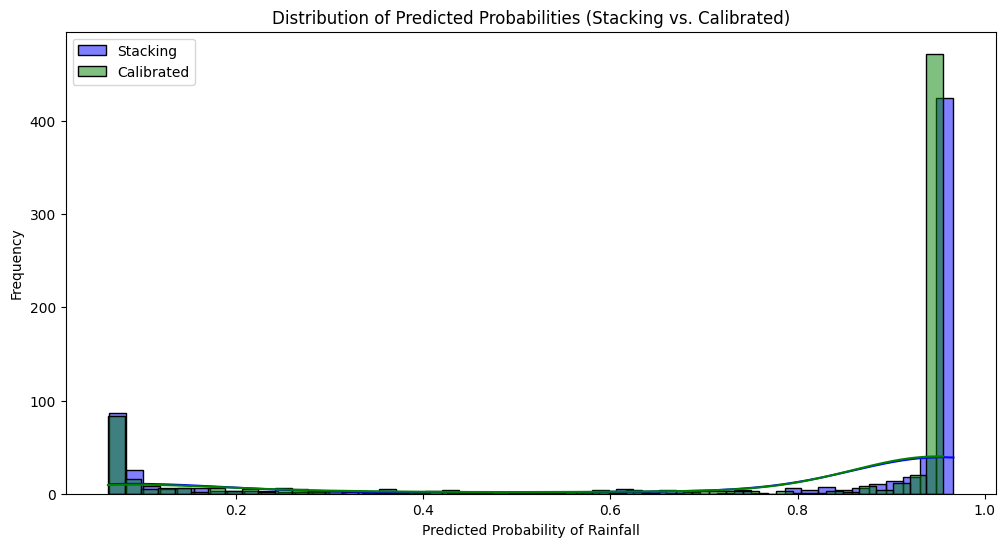

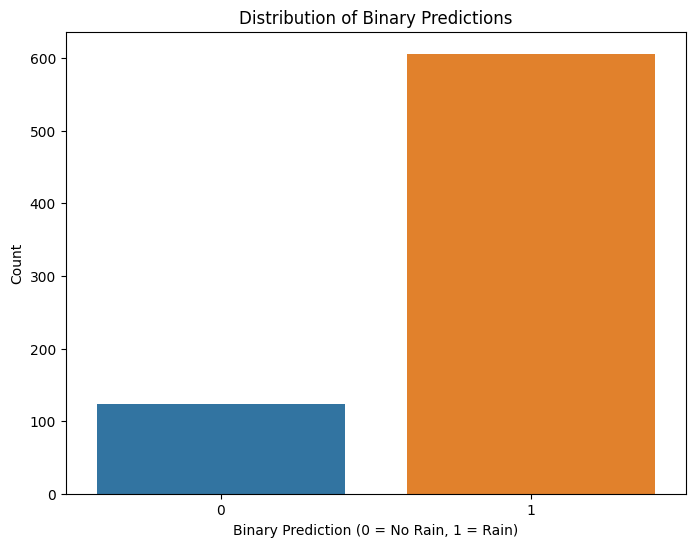

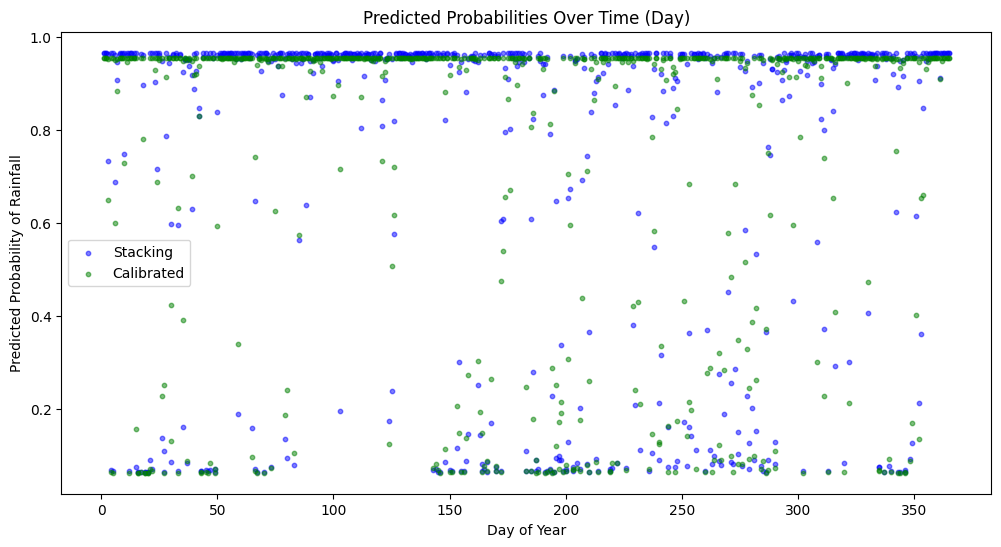

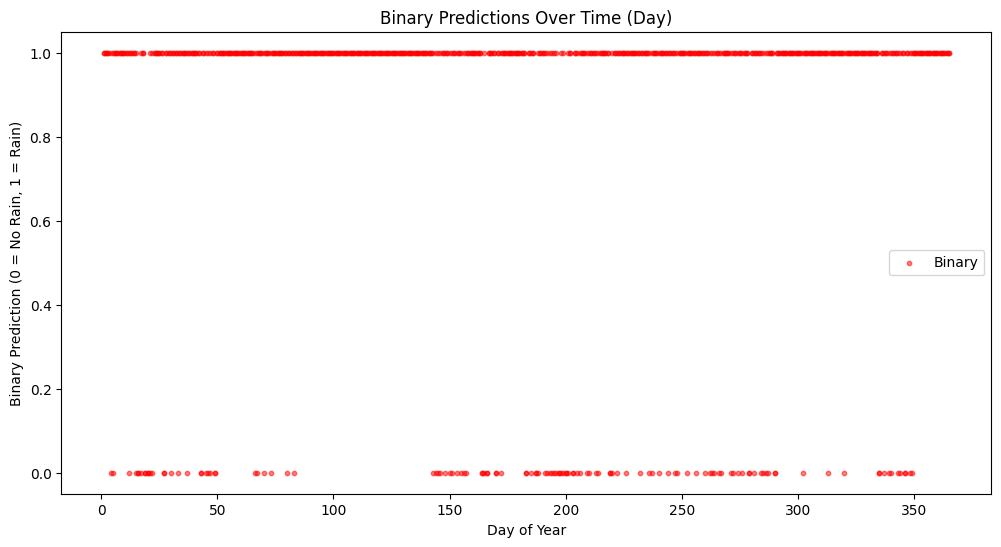

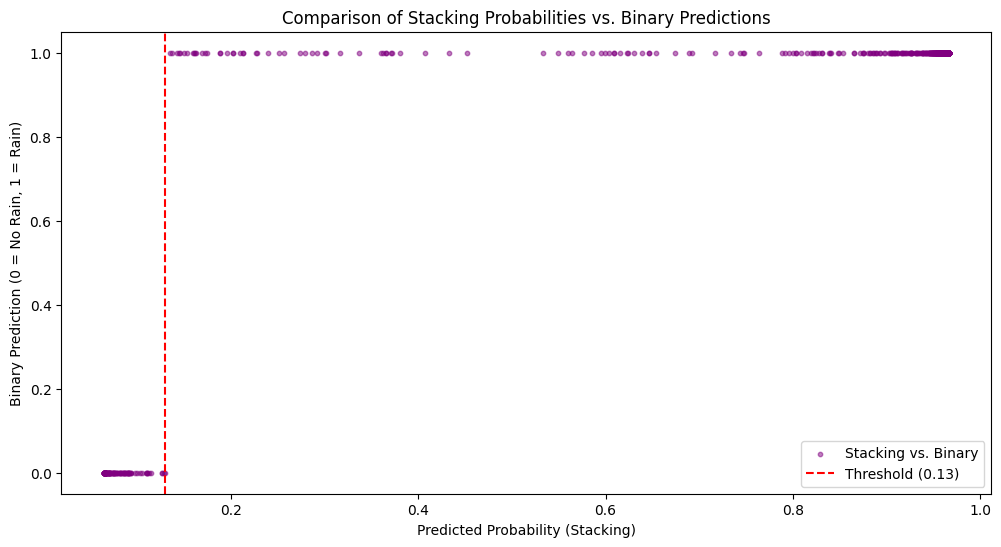

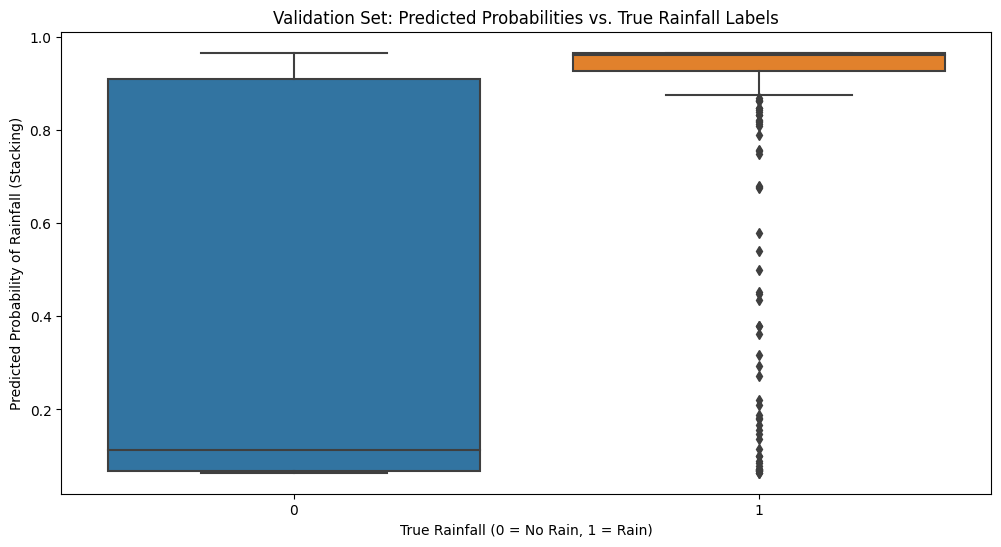

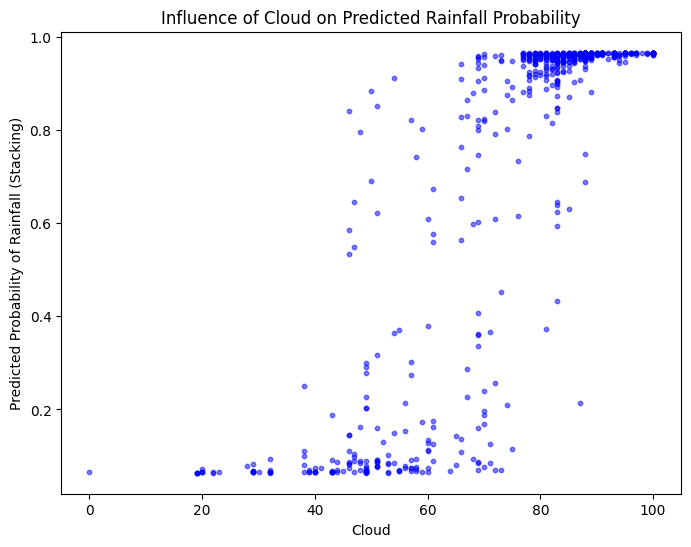

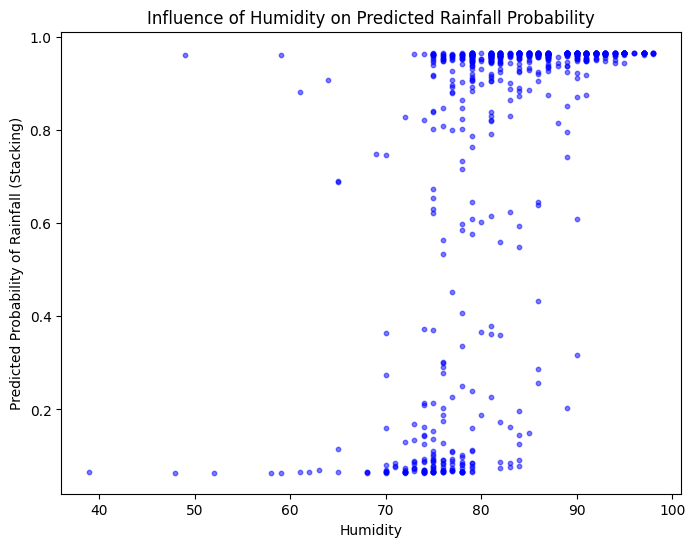

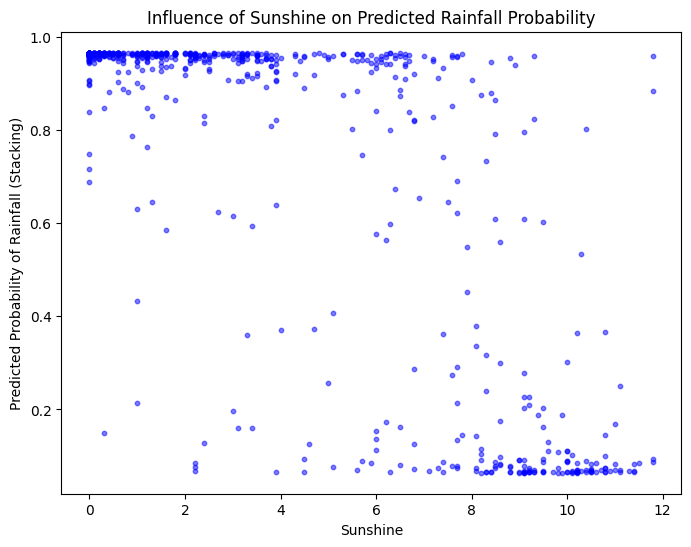


Stacking Submission Data (First 5 Rows):
+------+------------+
|   id |   rainfall |
|------+------------|
| 2190 |  0.966514  |
| 2191 |  0.966595  |
| 2192 |  0.963139  |
| 2193 |  0.0686287 |
| 2194 |  0.0656685 |
+------+------------+

Binary Submission Data (First 5 Rows):
+------+------------+
|   id |   rainfall |
|------+------------|
| 2190 |          1 |
| 2191 |          1 |
| 2192 |          1 |
| 2193 |          0 |
| 2194 |          0 |
+------+------------+

Calibrated Submission Data (First 5 Rows):
+------+------------+
|   id |   rainfall |
|------+------------|
| 2190 |  0.95548   |
| 2191 |  0.955505  |
| 2192 |  0.954047  |
| 2193 |  0.0648138 |
| 2194 |  0.0630903 |
+------+------------+


In [40]:
# ==============================
# Visualizations for Submissions
# ==============================

print("\n=== Visualizing Submission Predictions ===")

# 1. Distribution of Predicted Probabilities Across Submissions
plt.figure(figsize=(12, 6))
sns.histplot(submission_stack['rainfall'], kde=True, label='Stacking', color='blue', alpha=0.5, bins=50)
sns.histplot(submission_calibrated['rainfall'], kde=True, label='Calibrated', color='green', alpha=0.5, bins=50)
plt.xlabel('Predicted Probability of Rainfall')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities (Stacking vs. Calibrated)')
plt.legend()
plt.show()

# Note: submission_binary contains binary predictions (0 or 1), so we'll plot its distribution separately
plt.figure(figsize=(8, 6))
sns.countplot(x='rainfall', data=submission_binary)
plt.xlabel('Binary Prediction (0 = No Rain, 1 = Rain)')
plt.ylabel('Count')
plt.title('Distribution of Binary Predictions')
plt.show()

# 2. Predicted Probabilities Over Time (Day)
# Merge test_data['day'] with the submission predictions
submission_stack_with_day = submission_stack.copy()
submission_stack_with_day['day'] = test_data['day']
submission_calibrated_with_day = submission_calibrated.copy()
submission_calibrated_with_day['day'] = test_data['day']
submission_binary_with_day = submission_binary.copy()
submission_binary_with_day['day'] = test_data['day']

plt.figure(figsize=(12, 6))
plt.scatter(submission_stack_with_day['day'], submission_stack_with_day['rainfall'], 
            label='Stacking', alpha=0.5, color='blue', s=10)
plt.scatter(submission_calibrated_with_day['day'], submission_calibrated_with_day['rainfall'], 
            label='Calibrated', alpha=0.5, color='green', s=10)
plt.xlabel('Day of Year')
plt.ylabel('Predicted Probability of Rainfall')
plt.title('Predicted Probabilities Over Time (Day)')
plt.legend()
plt.show()

# Plot binary predictions over time
plt.figure(figsize=(12, 6))
plt.scatter(submission_binary_with_day['day'], submission_binary_with_day['rainfall'], 
            label='Binary', alpha=0.5, color='red', s=10)
plt.xlabel('Day of Year')
plt.ylabel('Binary Prediction (0 = No Rain, 1 = Rain)')
plt.title('Binary Predictions Over Time (Day)')
plt.legend()
plt.show()

# 3. Comparison of Predictions (Binary vs. Probability)
plt.figure(figsize=(12, 6))
plt.scatter(submission_stack['rainfall'], submission_binary['rainfall'], 
            label='Stacking vs. Binary', alpha=0.5, color='purple', s=10)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Threshold ({optimal_threshold:.2f})')
plt.xlabel('Predicted Probability (Stacking)')
plt.ylabel('Binary Prediction (0 = No Rain, 1 = Rain)')
plt.title('Comparison of Stacking Probabilities vs. Binary Predictions')
plt.legend()
plt.show()

# 4. Validation Set: Predicted Probabilities vs. True Labels
# Use the stacking predictions on the validation set (y_pred_stack)
val_predictions_df = pd.DataFrame({
    'True Rainfall': y_val,
    'Predicted Probability': y_pred_stack
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='True Rainfall', y='Predicted Probability', data=val_predictions_df)
plt.title('Validation Set: Predicted Probabilities vs. True Rainfall Labels')
plt.xlabel('True Rainfall (0 = No Rain, 1 = Rain)')
plt.ylabel('Predicted Probability of Rainfall (Stacking)')
plt.show()

# 5. Feature Influence on Predictions
# Select a few key features to analyze their influence on predictions
key_features = ['cloud', 'humidity', 'sunshine']
for feature in key_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(test_data[feature], submission_stack['rainfall'], 
                alpha=0.5, color='blue', s=10)
    plt.xlabel(feature.capitalize())
    plt.ylabel('Predicted Probability of Rainfall (Stacking)')
    plt.title(f'Influence of {feature.capitalize()} on Predicted Rainfall Probability')
    plt.show()

# Display first 5 rows of submissions with tabulate (already in your code)
print("\nStacking Submission Data (First 5 Rows):")
print(tabulate(submission_stack.head(), headers='keys', tablefmt='psql', showindex=False))

print("\nBinary Submission Data (First 5 Rows):")
print(tabulate(submission_binary.head(), headers='keys', tablefmt='psql', showindex=False))

print("\nCalibrated Submission Data (First 5 Rows):")
print(tabulate(submission_calibrated.head(), headers='keys', tablefmt='psql', showindex=False))